In [1]:
import pandas as pd
import numpy as np
import glob
import pytz
import os
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
import xgboost as xgb
import optuna
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter

warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')
warnings.filterwarnings('ignore', category=FutureWarning)

/opt/anaconda3/envs/diss/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load in Data
EVENTS_FOLDER = '../../data/bishkek_csr/03_train_ready/event_exports' 
RESPECK_FOLDER = '../../data/bishkek_csr/03_train_ready/respeck'
NASAL_FOLDER = '../../data/bishkek_csr/03_train_ready/nasal_files'

# --- STRATEGIC FIX: Re-group the rarest classes ---
EVENT_GROUP_TO_LABEL = {
    1: ['Obstructive Apnea'],
    2: ['Hypopnea', 'Central Hypopnea', 'Obstructive Hypopnea'],
    3: ['Central Apnea', 'Mixed Apnea', 'RERA'], # Combined rare events
    4: ['Desaturation'] # Note: Relabeled from 5 to 4
}

LABEL_TO_EVENT_GROUP_NAME = {
    0: 'Normal',
    1: 'Obstructive Apnea',
    2: 'Hypopnea Events',
    3: 'Other Apnea/RERA', # New combined name
    4: 'Desaturation'
}

# --- Feature Generation Functions (Unchanged) ---
def generate_RRV(sliced_signal):
    # (Your existing generate_RRV function code here)
    sliced_signal = sliced_signal.dropna()
    if sliced_signal.empty: return np.nan
    breathingSignal = sliced_signal.values
    N = len(breathingSignal)
    if N < 2: return 0.0
    yf = np.fft.fft(breathingSignal)
    yff = 2.0 / N * np.abs(yf[:N//2])
    if len(yff) < 2: return 0.0
    dc_component_value = np.amax(yff)
    if dc_component_value == 0: return 0.0
    temp_dc_removed = np.delete(yff, np.argmax(yff))
    h1_value = np.amax(temp_dc_removed)
    rrv = 100 - (h1_value / dc_component_value) * 100
    return rrv

def extract_respeck_features(df):
    # (Your existing extract_respeck_features function code here)
    resampled_df = pd.DataFrame()
    br_resampler = df["breathingRate"].resample('30s')
    resampled_df["BR_median"], resampled_df["BR_mean"], resampled_df["BR_std"] = br_resampler.median(), br_resampler.mean(), br_resampler.std()
    resampled_df["BR_cov"] = resampled_df["BR_std"] / resampled_df["BR_mean"]
    al_resampler = df["activityLevel"].resample('30s')
    resampled_df["AL_median"], resampled_df["AL_mean"], resampled_df["AL_std"] = al_resampler.median(), al_resampler.mean(), al_resampler.std()
    resampled_df["AL_cov"] = resampled_df["AL_std"] / resampled_df["AL_mean"]
    resampled_df["RRV"] = df["breathingSignal"].resample('30s').apply(generate_RRV)
    resampled_df["RRV"] = resampled_df["RRV"].replace(0, np.nan).ffill().bfill()
    resampled_df["RRV3ANN"] = resampled_df["RRV"].rolling(window=3, center=True).mean()
    resampled_df["RRV3ANN"] = resampled_df["RRV3ANN"] * 0.65
    resampled_df['Label'] = df['Label'].resample('30s').apply(lambda x: stats.mode(x)[0] if not x.empty else 0)
    return resampled_df

# --- Data Preparation Loop ---
all_sessions_df_list = []
# (The rest of your data loading loop remains the same, it will now use the new EVENT_GROUP_TO_LABEL map)
event_files = glob.glob(os.path.join(EVENTS_FOLDER, '*_event_export.csv'))
for event_file_path in event_files:
    base_name = os.path.basename(event_file_path)
    session_id = base_name.split('_event_export.csv')[0]
    respeck_file_path = os.path.join(RESPECK_FOLDER, f'{session_id}_respeck.csv')
    if not os.path.exists(respeck_file_path): continue
    
    df_events = pd.read_csv(event_file_path, decimal=',')
    df_respeck = pd.read_csv(respeck_file_path)
    
    df_events.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True)
    df_respeck.rename(columns={'alignedTimestamp': 'timestamp_unix'}, inplace=True)
    for df_ in [df_events, df_respeck]:
        df_['timestamp_unix'] = pd.to_numeric(df_['timestamp_unix'], errors='coerce')
        df_.dropna(subset=['timestamp_unix'], inplace=True)
        df_['timestamp_unix'] = df_['timestamp_unix'].astype('int64')

    df_respeck['timestamp'] = pd.to_datetime(df_respeck['timestamp_unix'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Asia/Bishkek')
    df_respeck['Label'] = 0
    df_events['Duration_ms'] = (df_events['Duration'] * 1000).astype('int64')
    df_events['end_time_unix'] = df_events['timestamp_unix'] + df_events['Duration_ms']
    
    for label_id, event_names_in_group in EVENT_GROUP_TO_LABEL.items():
        df_filtered_events = df_events[df_events['Event'].isin(event_names_in_group)]
        for _, event in df_filtered_events.iterrows():
            df_respeck.loc[df_respeck['timestamp_unix'].between(event['timestamp_unix'], event['end_time_unix']), 'Label'] = label_id
    
    df_respeck.set_index('timestamp', inplace=True)
    features_df = extract_respeck_features(df_respeck).dropna()
    features_df['SessionID'] = session_id
    all_sessions_df_list.append(features_df)

final_df = pd.concat(all_sessions_df_list).reset_index().rename(columns={'index': 'timestamp'})
print(f"\nData loading and feature generation complete. Final shape: {final_df.shape}")
print(f"Final class distribution:\n{final_df['Label'].value_counts(normalize=True)}")

# --- Prepare data for the model ---
FEATURE_COLUMNS = ['BR_median', 'BR_mean', 'BR_std', 'BR_cov', 'AL_median', 'AL_mean', 'AL_std', 'AL_cov', 'RRV', 'RRV3ANN']
X = final_df[FEATURE_COLUMNS].values
y = final_df['Label'].values
groups = final_df['SessionID'].values
X = SimpleImputer(strategy='mean').fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)
N_OUTPUTS = len(le.classes_)
CLASS_NAMES = [LABEL_TO_EVENT_GROUP_NAME[c] for c in le.classes_]

print(f"\nTotal classes for model: {N_OUTPUTS}. Names: {CLASS_NAMES}")


Data loading and feature generation complete. Final shape: (7796, 13)
Final class distribution:
Label
0    0.908286
4    0.061570
2    0.026552
1    0.003335
3    0.000257
Name: proportion, dtype: float64

Total classes for model: 5. Names: ['Normal', 'Obstructive Apnea', 'Hypopnea Events', 'Other Apnea/RERA', 'Desaturation']


In [3]:
from sklearn.metrics import f1_score # Add this import at the top of the cell

class ImprovedXGBoostClassifier:
    def __init__(self, feature_columns, n_outputs, random_state=42):
        self.feature_columns = feature_columns
        self.n_outputs = n_outputs
        self.random_state = random_state
        self.scaler = RobustScaler()
        self.best_params = None
        self.le = None # Add a spot to store the label encoder

    def create_advanced_features(self, X_df):
        # This method is unchanged and correct.
        X_advanced = X_df.copy()
        X_advanced['BR_AL_interaction'] = X_advanced['BR_mean'] * X_advanced['AL_mean']
        X_advanced['BR_RRV_interaction'] = X_advanced['BR_mean'] * X_advanced['RRV']
        X_advanced['BR_median_mean_ratio'] = X_advanced['BR_median'] / (X_advanced['BR_mean'] + 1e-8)
        X_advanced['BR_mean_squared'] = X_advanced['BR_mean'] ** 2
        X_advanced['AL_mean_squared'] = X_advanced['AL_mean'] ** 2
        X_advanced['RRV_squared'] = X_advanced['RRV'] ** 2
        X_advanced['BR_stability'] = 1 / (1 + X_advanced['BR_cov'])
        X_advanced['activity_breathing_score'] = (X_advanced['AL_mean'] * 0.6 + X_advanced['BR_mean'] * 0.4)
        X_advanced['BR_mean_lag1'] = X_advanced['BR_mean'].shift(1)
        X_advanced['RRV_lag1'] = X_advanced['RRV'].shift(1)
        X_advanced['BR_mean_diff1'] = X_advanced['BR_mean'].diff(1)
        X_advanced['RRV_diff1'] = X_advanced['RRV'].diff(1)
        rolling_window = 3
        X_advanced['BR_rolling_std'] = X_advanced['BR_mean'].rolling(window=rolling_window, center=True).std()
        X_advanced['RRV_rolling_std'] = X_advanced['RRV'].rolling(window=rolling_window, center=True).std()
        X_advanced = X_advanced.replace([np.inf, -np.inf], np.nan).fillna(method='bfill').fillna(method='ffill')
        X_advanced = X_advanced.fillna(X_advanced.median())
        return X_advanced

    def optimize_hyperparameters(self, X_train, y_train, n_trials=50, use_weights=False):
        print("  - Optimizing hyperparameters with a custom scorer for 'Obstructive Apnea'...")

        # --- NEW: Identify the encoded label for our target class ---
        # Find the integer label that corresponds to the original class '1' (Obstructive Apnea)
        target_class_original_label = 1 
        if target_class_original_label not in self.le.classes_:
             print(f"  - WARNING: Target class {target_class_original_label} not in this fold's data. Optimizing for balanced accuracy.")
             target_class_encoded = -1 # Sentinel value
        else:
            target_class_encoded = self.le.transform([target_class_original_label])[0]
            print(f"  - 'Obstructive Apnea' (original label {target_class_original_label}) is encoded as {target_class_encoded}.")

        # --- NEW: Define the custom scorer function ---
        def obstructive_apnea_focused_scorer(y_true, y_pred):
            # If our target class isn't in the data, fall back to balanced accuracy
            if target_class_encoded == -1 or target_class_encoded not in y_true:
                return balanced_accuracy_score(y_true, y_pred)

            # Calculate F1 score for each class
            f1_scores = f1_score(y_true, y_pred, average=None, labels=np.unique(y_true), zero_division=0)
            unique_labels = np.unique(y_true)
            
            # Create a weight map
            # Give a massive weight to our target class, and tiny weights to others
            weight_map = {label: 0.05 for label in unique_labels}
            weight_map[target_class_encoded] = 1.0 # The star of the show
            
            # Normalize weights to sum to 1
            total_weight = sum(weight_map.values())
            weights = np.array([weight_map[label] / total_weight for label in unique_labels])
            
            # Calculate the final weighted F1 score
            weighted_f1 = np.sum(f1_scores * weights)
            return weighted_f1

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.random_state)
        
        def objective(trial):
            params = {
                'objective': 'multi:softmax', 'num_class': self.n_outputs,
                'eval_metric': 'mlogloss', 'random_state': self.random_state,
                'n_jobs': -1, 'verbosity': 0, 'tree_method': 'hist',
                'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=100),
                'max_depth': trial.suggest_int('max_depth', 4, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
                'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 5.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 5.0, log=True),
            }
            scores = []
            for tr_idx, val_idx in skf.split(X_train, y_train):
                X_tr, X_val = X_train[tr_idx], X_train[val_idx]
                y_tr, y_val = y_train[tr_idx], y_train[val_idx]
                
                fit_params = {}
                if use_weights:
                    class_weights_array = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
                    weight_map = {label: weight for label, weight in zip(np.unique(y_tr), class_weights_array)}
                    fit_params['sample_weight'] = [weight_map[label] for label in y_tr]

                model = xgb.XGBClassifier(**params)
                model.fit(X_tr, y_tr, **fit_params)
                y_pred = model.predict(X_val)
                # --- Use our custom scorer ---
                scores.append(obstructive_apnea_focused_scorer(y_val, y_pred))
            return np.mean(scores)
        
        study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        self.best_params = study.best_params
        print(f"  - Best custom score from optimization: {study.best_value:.4f}")
        return self.best_params

    def cross_validate(self, X, y_encoded, le, groups, use_optimization=True):
        self.le = le # Store the label encoder for use in the optimizer
        
        X_df = pd.DataFrame(X, columns=self.feature_columns)
        X_engineered = self.create_advanced_features(X_df)
        print(f"  - Feature engineering applied: {X_df.shape[1]} -> {X_engineered.shape[1]} features")

        all_preds_encoded, all_true_encoded, all_importances = [], [], []
        logo = LeaveOneGroupOut()
        n_folds = logo.get_n_splits(X_engineered, y_encoded, groups=groups)
        
        print(f"Starting LONO CV with {n_folds} folds...")
        print("=" * 60)
        
        # The rest of this method uses the same robust logic as before
        for fold, (train_idx, test_idx) in enumerate(logo.split(X_engineered, y_encoded, groups)):
            test_night = np.unique(groups[test_idx])[0]
            print(f"\\n--- FOLD {fold + 1}/{n_folds} (Testing: {test_night}) ---")

            X_train, X_test = X_engineered.iloc[train_idx].values, X_engineered.iloc[test_idx].values
            y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
            
            print(f"  - Original training distribution: {Counter(y_train)}")

            X_train_aug, y_train_aug = X_train.copy(), y_train.copy()
            unique_in_fold = np.unique(y_train_aug)
            missing_classes = np.setdiff1d(le.classes_, unique_in_fold)

            if len(missing_classes) > 0:
                print(f"  - Injecting dummy samples for missing classes: {missing_classes}")
                dummy_features = np.mean(X_train_aug, axis=0, keepdims=True)
                for cls in missing_classes:
                    X_train_aug = np.vstack([X_train_aug, dummy_features])
                    y_train_aug = np.append(y_train_aug, cls)
            
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train_aug)
            X_test_scaled = scaler.transform(X_test)
            
            class_counts = Counter(y_train_aug)
            min_class_size = min(class_counts.values())
            
            fit_params = {}
            if min_class_size < 2:
                print(f"  - Smallest class has {min_class_size} sample(s). Falling back to sample weighting.")
                X_res, y_res = X_train_scaled, y_train_aug
                
                class_weights_array = compute_class_weight('balanced', classes=le.classes_, y=y_res)
                weight_map = {label: weight for label, weight in zip(le.classes_, class_weights_array)}
                fit_params['sample_weight'] = [weight_map[label] for label in y_res]
                
                if use_optimization and self.best_params is None:
                    self.best_params = self.optimize_hyperparameters(X_res, y_res, n_trials=30, use_weights=True)
            else:
                smote_k_neighbors = min_class_size - 1
                print(f"  - Smallest class has {min_class_size} samples. Using SMOTETomek with k_neighbors={smote_k_neighbors}.")
                resampler = SMOTETomek(
                    smote=SMOTE(k_neighbors=smote_k_neighbors, random_state=self.random_state),
                    random_state=self.random_state, n_jobs=-1
                )
                X_res, y_res = resampler.fit_resample(X_train_scaled, y_train_aug)
                print(f"  - Resampled training distribution: {Counter(y_res)}")
                
                if use_optimization and self.best_params is None:
                    self.best_params = self.optimize_hyperparameters(X_res, y_res, n_trials=30, use_weights=False)

            params = self.best_params or {}
            params.update({
                'objective': 'multi:softmax', 'num_class': self.n_outputs,
                'eval_metric': 'mlogloss', 'random_state': self.random_state,
                'n_jobs': -1, 'verbosity': 0, 'tree_method': 'hist'
            })
            
            model = xgb.XGBClassifier(**params)
            model.fit(X_res, y_res, **fit_params)

            y_pred_encoded = model.predict(X_test_scaled)
            all_preds_encoded.extend(y_pred_encoded)
            all_true_encoded.extend(y_test)
            
            print(f"  - Fold balanced accuracy: {balanced_accuracy_score(y_test, y_pred_encoded):.4f}")
            
            importance_df = pd.DataFrame({
                'feature': X_engineered.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            all_importances.append(importance_df)

        self.model = model
        self._display_results(le, all_true_encoded, all_preds_encoded, all_importances)

    def _display_results(self, le, true_encoded, pred_encoded, importances):
        # This method is unchanged
        print("\\n" + "=" * 60 + "\\nAGGREGATED XGBOOST RESULTS\\n" + "=" * 60)
        true_labels_orig = le.inverse_transform(true_encoded)
        pred_labels_orig = le.inverse_transform(pred_encoded)
        class_names_ordered = [LABEL_TO_EVENT_GROUP_NAME[c] for c in le.classes_]
        print(f"Overall Balanced Accuracy: {balanced_accuracy_score(true_encoded, pred_encoded):.4f}\\n")
        print(classification_report(true_labels_orig, pred_labels_orig, target_names=class_names_ordered, labels=le.classes_, zero_division=0))
        cm = confusion_matrix(true_labels_orig, pred_labels_orig, labels=le.classes_)
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_norm = np.nan_to_num(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names_ordered, yticklabels=class_names_ordered)
        plt.title('Aggregated Normalized Confusion Matrix (LONO)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        self._plot_feature_importance(importances)
        
    def _plot_feature_importance(self, importances):
        # This method is unchanged
        all_imp_df = pd.concat(importances)
        mean_imp_df = all_imp_df.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()
        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=mean_imp_df.head(15), palette='viridis')
        plt.xlabel('Mean Feature Importance (Gain)')
        plt.ylabel('Feature')
        plt.title('Top 15 Feature Importances (Averaged Across Folds)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# --- Define data for the model ---
df = final_df.copy()

FEATURE_COLUMNS = [
    'BR_median', 'BR_mean', 'BR_std', 'BR_cov', 
    'AL_median', 'AL_mean', 'AL_std', 'AL_cov',
    'RRV', 'RRV3ANN'
]
LABEL_COLUMN = 'Label' 
SESSION_ID_COLUMN = 'SessionID'
RANDOM_STATE = 42

# --- Create final X, y, and groups arrays ---
X = df[FEATURE_COLUMNS].values
y = df[LABEL_COLUMN].values
groups = df[SESSION_ID_COLUMN].values

# --- Impute any remaining NaNs ---
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# --- NEW: Initialize and fit LabelEncoder on the entire dataset's labels ---
# This makes the encoder aware of ALL possible classes (0 through 5)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
# N_OUTPUTS should now be based on the number of classes found by the encoder
N_OUTPUTS = len(le.classes_) 
# Update CLASS_NAMES to match the order found by the encoder
CLASS_NAMES = [LABEL_TO_EVENT_GROUP_NAME[c] for c in le.classes_]


print("\nData preparation complete.")
print(f"Shape of X (features): {X.shape} -> (Num_Windows, Num_Engineered_Features)")
print(f"Shape of y (labels):   {y_encoded.shape}")
print(f"Original class distribution: {Counter(y)}")
print(f"Encoded class distribution: {Counter(y_encoded)}")
print(f"Total number of classes detected: {N_OUTPUTS}")


Data preparation complete.
Shape of X (features): (7796, 10) -> (Num_Windows, Num_Engineered_Features)
Shape of y (labels):   (7796,)
Original class distribution: Counter({np.int64(0): 7081, np.int64(4): 480, np.int64(2): 207, np.int64(1): 26, np.int64(3): 2})
Encoded class distribution: Counter({np.int64(0): 7081, np.int64(4): 480, np.int64(2): 207, np.int64(1): 26, np.int64(3): 2})
Total number of classes detected: 5


In [5]:
print("\nChecking for and imputing missing values (NaNs)...")
for col in df:
    if col in df.columns:
        nan_count = df[col].isnull().sum()
        if nan_count > 0:
            print(f"  - Found {nan_count} NaNs in '{col}'. Applying forward-fill and backward-fill.")
            
            # Step 1: Forward-fill handles all NaNs except leading ones.
            df[col].ffill(inplace=True) 
            
            # Step 2: Backward-fill handles any remaining NaNs at the beginning of the file.
            df[col].bfill(inplace=True) 

# Add a final check to ensure everything is clean
final_nan_count = df[FEATURE_COLUMNS].isnull().sum().sum()
if final_nan_count > 0:
    print(f"\nWARNING: {final_nan_count} NaNs still remain in feature columns after imputation. Please investigate.")
else:
    print("\nImputation complete. No NaNs remain in feature columns.")


Checking for and imputing missing values (NaNs)...

Imputation complete. No NaNs remain in feature columns.


In [6]:
# device = torch.device(
#     "cuda" if torch.cuda.is_available()
#     else ("mps" if torch.backends.mps.is_available() else "cpu")
# )
# print(f"Using device: {device}")

  - Feature engineering applied: 10 -> 24 features
Starting LONO CV with 9 folds...
\n--- FOLD 1/9 (Testing: 04-04-2025) ---
  - Original training distribution: Counter({np.int64(0): 6042, np.int64(4): 414, np.int64(2): 201, np.int64(1): 24, np.int64(3): 2})
  - Smallest class has 2 samples. Using SMOTETomek with k_neighbors=1.


[I 2025-07-14 23:30:58,430] A new study created in memory with name: no-name-c2cf88c1-c63e-4dd9-bce5-bbebd7305594


  - Resampled training distribution: Counter({np.int64(0): 6042, np.int64(2): 6042, np.int64(4): 6042, np.int64(1): 6042, np.int64(3): 6042})
  - Optimizing hyperparameters with a custom scorer for 'Obstructive Apnea'...
  - 'Obstructive Apnea' (original label 1) is encoded as 1.


[I 2025-07-14 23:31:44,714] Trial 0 finished with value: 0.9951355527510594 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.04295827412116829, 'subsample': 0.7470701033829155, 'colsample_bytree': 0.9198278118629439, 'reg_alpha': 0.08156412262201318, 'reg_lambda': 1.3658007834109729e-06}. Best is trial 0 with value: 0.9951355527510594.
[I 2025-07-14 23:32:36,442] Trial 1 finished with value: 0.9956543834188518 and parameters: {'n_estimators': 700, 'max_depth': 6, 'learning_rate': 0.15229531315937656, 'subsample': 0.7132801750499186, 'colsample_bytree': 0.9073771182357853, 'reg_alpha': 1.0444145145829094e-08, 'reg_lambda': 0.0005897425699743434}. Best is trial 1 with value: 0.9956543834188518.
[I 2025-07-14 23:34:19,580] Trial 2 finished with value: 0.9887621396083596 and parameters: {'n_estimators': 900, 'max_depth': 6, 'learning_rate': 0.010730822117713172, 'subsample': 0.7014282945686817, 'colsample_bytree': 0.8708158812243372, 'reg_alpha': 0.00113445301782448

  - Best custom score from optimization: 0.9964
  - Fold balanced accuracy: 0.2603
\n--- FOLD 2/9 (Testing: 05-04-2025) ---
  - Original training distribution: Counter({np.int64(0): 6402, np.int64(4): 348, np.int64(2): 164, np.int64(1): 21, np.int64(3): 2})
  - Smallest class has 2 samples. Using SMOTETomek with k_neighbors=1.
  - Resampled training distribution: Counter({np.int64(0): 6402, np.int64(2): 6402, np.int64(4): 6402, np.int64(1): 6402, np.int64(3): 6402})
  - Fold balanced accuracy: 0.2931
\n--- FOLD 3/9 (Testing: 08-05-2025) ---
  - Original training distribution: Counter({np.int64(0): 6486, np.int64(4): 416, np.int64(2): 175, np.int64(1): 25, np.int64(3): 2})
  - Smallest class has 2 samples. Using SMOTETomek with k_neighbors=1.
  - Resampled training distribution: Counter({np.int64(0): 6486, np.int64(2): 6486, np.int64(4): 6486, np.int64(1): 6486, np.int64(3): 6486})
  - Fold balanced accuracy: 0.2812
\n--- FOLD 4/9 (Testing: 10-05-2025) ---
  - Original training distribu

/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  - Fold balanced accuracy: 0.3422
\n============================================================\nAGGREGATED XGBOOST RESULTS\n============================================================
Overall Balanced Accuracy: 0.2216\n
                   precision    recall  f1-score   support

           Normal       0.92      0.95      0.93      7081
Obstructive Apnea       0.00      0.00      0.00        26
  Hypopnea Events       0.11      0.03      0.05       207
 Other Apnea/RERA       0.00      0.00      0.00         2
     Desaturation       0.17      0.12      0.14       480

         accuracy                           0.87      7796
        macro avg       0.24      0.22      0.23      7796
     weighted avg       0.84      0.87      0.86      7796



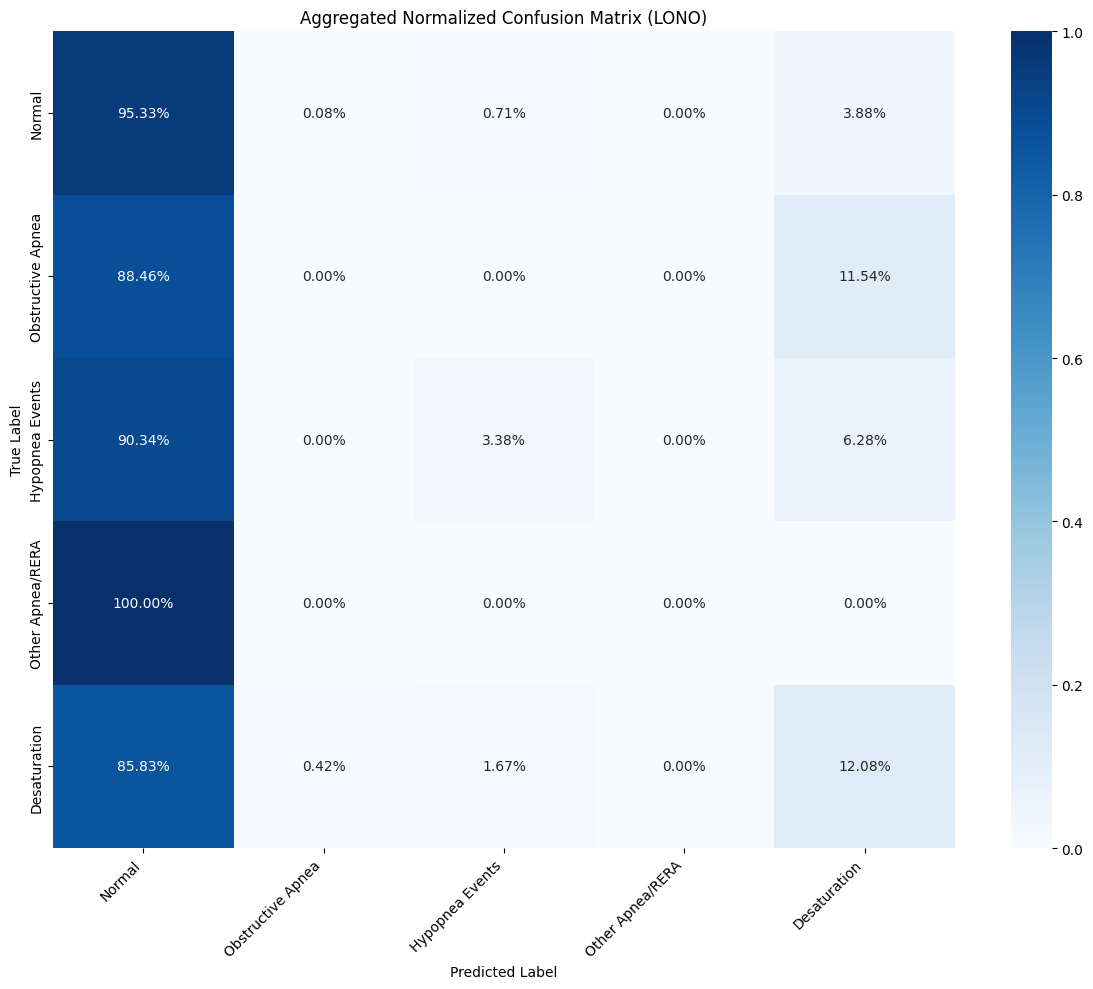

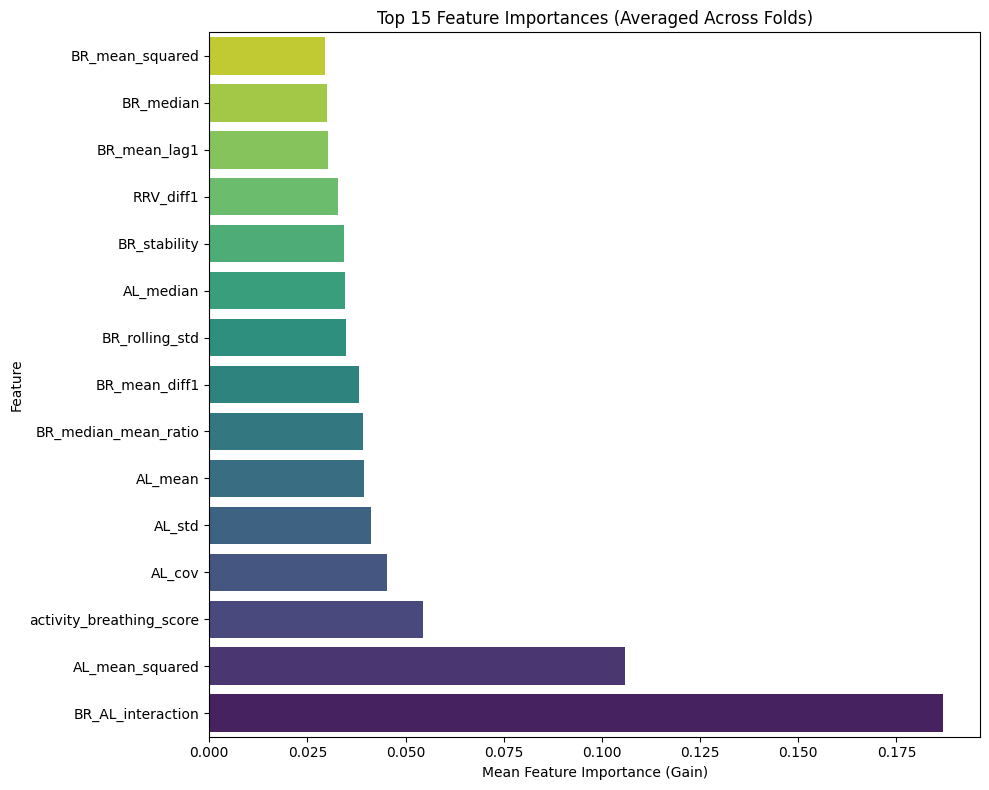

In [7]:
def run_improved_model(X, y_encoded, le, groups, feature_columns, n_outputs):
    improved_classifier = ImprovedXGBoostClassifier(
        feature_columns=feature_columns,
        n_outputs=n_outputs,
        random_state=42
    )
    
    improved_classifier.cross_validate(
        X=X, 
        y_encoded=y_encoded,
        le=le,
        groups=groups,
        use_optimization=True 
    )
    
    return improved_classifier

# Execute the pipeline
CLASS_NAMES_ORDERED = [LABEL_TO_EVENT_GROUP_NAME[c] for c in le.classes_]

improved_model = run_improved_model(
    X=X, 
    y_encoded=y_encoded, 
    le=le,
    groups=groups, 
    feature_columns=FEATURE_COLUMNS,
    n_outputs=N_OUTPUTS
)

In [8]:
# import xgboost as xgb
# from imblearn.over_sampling import SMOTE, RandomOverSampler
# from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.metrics import classification_report, confusion_matrix
# from collections import Counter
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.inspection import permutation_importance

# # --- 1. Initialize lists to store results from all folds ---
# all_fold_predictions = []
# all_fold_true_labels = []
# all_fold_importances = []

# # --- 2. Setup Leave-One-Night-Out cross-validator ---
# logo = LeaveOneGroupOut()
# n_folds = logo.get_n_splits(X, y_encoded, groups=groups)
# print(f"Starting XGBoost Leave-One-Night-Out cross-validation with {n_folds} folds...")
# print("----------------------------------------------------\n")

# # --- 3. Loop through each fold ---
# for fold, (train_idx, test_idx) in enumerate(logo.split(X, y_encoded, groups)):
    
#     test_night = np.unique(groups[test_idx])[0]
#     print(f"--- FOLD {fold + 1}/{n_folds} (Testing on Night: {test_night}) ---")

#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train_fold_encoded, y_test_fold = y_encoded[train_idx], y_encoded[test_idx]
    
#     # --- FINAL FIX: Robust Resampling with Dummy Sample Injection ---
#     print(f"  - Original training distribution (encoded): {Counter(y_train_fold_encoded)}")
    
#     # Find classes missing from this fold's training data
#     all_possible_classes = set(range(N_OUTPUTS))
#     present_classes = set(np.unique(y_train_fold_encoded))
#     missing_classes = all_possible_classes - present_classes
    
#     X_train_augmented = X_train
#     y_train_augmented = y_train_fold_encoded
    
#     # If any classes are missing, inject a dummy sample for each
#     if missing_classes:
#         print(f"  - Injecting dummy samples for missing classes: {missing_classes}")
#         dummy_sample_X = X_train[0:1] # Take the first sample as a template
#         for mc in missing_classes:
#             X_train_augmented = np.vstack([X_train_augmented, dummy_sample_X])
#             y_train_augmented = np.hstack([y_train_augmented, [mc]])

#     # Now, use RandomOverSampler which is safe and guaranteed to work
#     ros = RandomOverSampler(random_state=RANDOM_STATE)
#     X_res, y_res = ros.fit_resample(X_train_augmented, y_train_augmented)
    
#     print(f"  - Resampled training distribution: {Counter(y_res)}")

#     # --- Initialize and Train the XGBoost model ---
#     model = xgb.XGBClassifier(
#         objective='multi:softmax',
#         num_class=N_OUTPUTS,
#         n_estimators=500,
#         learning_rate=0.0001,
#         max_depth=4,
#         eval_metric='mlogloss',
#         random_state=RANDOM_STATE,
#         n_jobs=-1
#     )
    
#     model.fit(X_res, y_res)
#     print(f"  - Training complete.")

#     # --- Evaluate and store results ---
#     fold_preds_encoded = model.predict(X_test)
    
#     # Inverse transform predictions and true labels to their original values for reporting
#     fold_preds_original = le.inverse_transform(fold_preds_encoded)
#     fold_true_original = le.inverse_transform(y_test_fold)

#     all_fold_predictions.extend(fold_preds_original)
#     all_fold_true_labels.extend(fold_true_original)
    
#     # --- Calculate and store feature importance ---
#     result = permutation_importance(
#         model, X_test, y_test_fold, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1, scoring='f1_weighted'
#     )
#     perm_importance = pd.DataFrame({'feature': FEATURE_COLUMNS, 'importance': result.importances_mean})
#     all_fold_importances.append(perm_importance)
    
#     print(f"  - Evaluation complete for fold {fold + 1}.\n")

# # --- FINAL AGGREGATED EVALUATION (after all folds are complete) ---
# # This part of the code remains the same as the previous correct version
# print("\n====================================================")
# print("XGBoost Leave-One-Night-Out Cross-Validation Complete.")
# print("Aggregated Results Across All Folds:")
# print("====================================================\n")

# print('Aggregated Classification Report')
# print('------------------------------')
# report_labels = le.classes_
# print(classification_report(
#     all_fold_true_labels, 
#     all_fold_predictions, 
#     labels=report_labels,
#     target_names=CLASS_NAMES,
#     zero_division=0
# ))

# print('\nAggregated Confusion Matrix')
# print('---------------------------')
# cm = confusion_matrix(all_fold_true_labels, all_fold_predictions, labels=report_labels)
# with np.errstate(divide='ignore', invalid='ignore'):
#     cm_norm = np.where(cm.sum(axis=1)[:, np.newaxis] > 0, cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 0)

# plt.figure(figsize=(12, 10))
# sns.heatmap(
#     cm_norm, annot=True, fmt='.2%', cmap='Greens',
#     xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES
# )
# plt.title('XGBoost - Aggregated Normalized Confusion Matrix (LONO)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.xticks(rotation=45, ha="right")
# plt.show()

# # --- SHAP Value Analysis ---
# print("\n--- SHAP Value Analysis (from last fold) ---")
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)

# for i, class_label in enumerate(le.classes_):
#     class_name = LABEL_TO_EVENT_GROUP_NAME[class_label]
#     print(f"\nSHAP Summary Plot for: {class_name} (Encoded as {i})")
#     try:
#         shap.summary_plot(shap_values[i], X_test, feature_names=FEATURE_COLUMNS, show=False)
#         plt.title(f"SHAP Values for {class_name}")
#         plt.show()
#     except Exception as e:
#         print(f"Could not plot SHAP for class {i}: {e}")

In [9]:
# # --- AGGREGATE AND PLOT FEATURE IMPORTANCES ---
# print("\n====================================================")
# print("Feature Importance Analysis (Averaged Across All Folds)")
# print("====================================================\n")

# # --- FIX: Aggregate Data from All Folds ---
# all_importances_df = pd.concat(all_fold_importances)
# mean_importance = all_importances_df.groupby('feature')['importance'].mean()
# std_importance = all_importances_df.groupby('feature')['importance'].std()

# # --- Prepare the DataFrame for Plotting ---
# final_importance_df = pd.DataFrame({
#     'mean_importance': mean_importance,
#     'std_importance': std_importance
# }).sort_values(by='mean_importance', ascending=False)

# # --- Create the Plot ---
# fig, ax = plt.subplots(figsize=(12, 8))
# plot_data = final_importance_df.head(10) # Plot top 10 features

# ax.barh(
#     y=plot_data.index,
#     width=plot_data['mean_importance'],
#     xerr=plot_data['std_importance'],
#     align='center',
#     ecolor='black',
#     capsize=5
# )

# ax.invert_yaxis() 
# ax.set_xlabel('Mean Permutation Importance (Weighted F1)')
# ax.set_ylabel('Feature')
# ax.set_title('Top 10 Feature Importances (Averaged Across LONO Folds)')
# ax.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [ ]:
import pandas as pd
import numpy as np
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from tsfresh.feature_selection.relevance import calculate_relevance_table
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import xgboost as xgb
import optuna
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

class TSFreshXGBoostClassifier:
    def __init__(self, target_class_label=1, random_state=42, feature_selection=True):
        """
        target_class_label: The original label for obstructive apnea (1 in your case)
        feature_selection: Whether to use tsfresh's feature selection
        """
        self.target_class_label = target_class_label
        self.random_state = random_state
        self.feature_selection = feature_selection
        self.scaler = RobustScaler()
        self.best_params = None
        self.selected_features = None
        self.le = None
        
    def prepare_accelerometer_data_for_tsfresh(self, df, window_size='30s'):
        """
        Prepare accelerometer data for tsfresh feature extraction
        
        df should have columns: timestamp, x, y, z, Label, SessionID
        """
        print(f"Preparing accelerometer data with {window_size} windows...")
        
        # Calculate magnitude
        df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
        
        # Create time-based windows
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        
        # Group by session and create windows
        windowed_data = []
        for session_id in df['SessionID'].unique():
            session_data = df[df['SessionID'] == session_id].copy()
            
            # Create windows
            windows = session_data.groupby(pd.Grouper(freq=window_size))
            
            for window_start, window_data in windows:
                if len(window_data) < 10:  # Skip very small windows
                    continue
                    
                # Get the most common label in this window
                window_label = window_data['Label'].mode().iloc[0] if not window_data['Label'].empty else 0
                
                # Create window ID
                window_id = f"{session_id}_{window_start.strftime('%Y%m%d_%H%M%S')}"
                
                # Prepare data for each axis
                for axis in ['x', 'y', 'z', 'magnitude']:
                    axis_data = window_data.reset_index()
                    axis_data = axis_data[['timestamp', axis]].copy()
                    axis_data['id'] = f"{window_id}_{axis}"
                    axis_data['time'] = range(len(axis_data))
                    axis_data = axis_data.rename(columns={axis: 'value'})
                    axis_data['window_id'] = window_id
                    axis_data['session_id'] = session_id
                    axis_data['label'] = window_label
                    axis_data['axis'] = axis
                    
                    windowed_data.append(axis_data[['id', 'time', 'value', 'window_id', 'session_id', 'label', 'axis']])
        
        return pd.concat(windowed_data, ignore_index=True)
    
    def extract_tsfresh_features(self, windowed_data, use_minimal=False):
        """
        Extract tsfresh features from windowed accelerometer data
        """
        print("Extracting tsfresh features...")
        
        # Choose feature extraction settings
        if use_minimal:
            fc_parameters = MinimalFCParameters()
            print("Using minimal feature set (faster)")
        else:
            fc_parameters = ComprehensiveFCParameters()
            print("Using comprehensive feature set (slower but more features)")
        
        # Extract features
        extracted_features = extract_features(
            windowed_data,
            column_id="id",
            column_sort="time", 
            column_value="value",
            default_fc_parameters=fc_parameters,
            n_jobs=-1  # Use all cores
        )
        
        # Impute missing values
        extracted_features = impute(extracted_features)
        
        print(f"Extracted {extracted_features.shape[1]} features from {extracted_features.shape[0]} time series")
        
        # Create metadata DataFrame
        metadata = windowed_data.groupby('id').first()[['window_id', 'session_id', 'label', 'axis']].reset_index()
        
        return extracted_features, metadata
    
    def select_relevant_features(self, features_df, metadata, target_col='label'):
        """
        Use tsfresh's feature selection to identify relevant features
        """
        if not self.feature_selection:
            return features_df
            
        print("Performing feature selection...")
        
        # Prepare target variable
        y = metadata.set_index('id')[target_col]
        
        # Ensure binary classification for feature selection
        # Focus on target class vs all others
        y_binary = (y == self.target_class_label).astype(int)
        
        # Select features
        selected_features = select_features(features_df, y_binary)
        
        print(f"Selected {selected_features.shape[1]} relevant features out of {features_df.shape[1]}")
        
        self.selected_features = selected_features.columns.tolist()
        return selected_features
    
    def aggregate_features_by_window(self, features_df, metadata):
        """
        Aggregate features from different axes for each window
        """
        print("Aggregating features by window...")
        
        # Add metadata to features
        features_with_meta = features_df.copy()
        features_with_meta = features_with_meta.merge(
            metadata.set_index('id'), 
            left_index=True, 
            right_index=True
        )
        
        # Aggregate by window (combining all axes)
        window_features = []
        
        for window_id in features_with_meta['window_id'].unique():
            window_data = features_with_meta[features_with_meta['window_id'] == window_id]
            
            # Get metadata
            session_id = window_data['session_id'].iloc[0]
            label = window_data['label'].iloc[0]
            
            # Aggregate features across axes
            feature_cols = [col for col in features_with_meta.columns 
                          if col not in ['window_id', 'session_id', 'label', 'axis']]
            
            aggregated_features = {}
            for col in feature_cols:
                # Create statistics across axes
                values = window_data[col].values
                aggregated_features[f"{col}_mean"] = np.mean(values)
                aggregated_features[f"{col}_std"] = np.std(values)
                aggregated_features[f"{col}_max"] = np.max(values)
                aggregated_features[f"{col}_min"] = np.min(values)
            
            # Add metadata
            aggregated_features['window_id'] = window_id
            aggregated_features['session_id'] = session_id
            aggregated_features['label'] = label
            
            window_features.append(aggregated_features)
        
        result_df = pd.DataFrame(window_features)
        print(f"Created {result_df.shape[1]-3} aggregated features for {result_df.shape[0]} windows")
        
        return result_df
    
    def optimize_hyperparameters(self, X_train, y_train, n_trials=50):
        """
        Optimize XGBoost hyperparameters with focus on obstructive apnea detection
        """
        print(f"Optimizing hyperparameters for obstructive apnea detection...")
        
        # Find encoded label for target class
        if self.target_class_label not in self.le.classes_:
            print(f"Warning: Target class {self.target_class_label} not in training data")
            target_class_encoded = -1
        else:
            target_class_encoded = self.le.transform([self.target_class_label])[0]
            print(f"Target class {self.target_class_label} encoded as {target_class_encoded}")
        
        def custom_scorer(y_true, y_pred):
            if target_class_encoded == -1 or target_class_encoded not in y_true:
                return balanced_accuracy_score(y_true, y_pred)
            
            # Weight F1 scores heavily toward target class
            f1_scores = f1_score(y_true, y_pred, average=None, zero_division=0)
            unique_labels = np.unique(y_true)
            
            weights = np.ones(len(unique_labels)) * 0.1
            if target_class_encoded in unique_labels:
                target_idx = np.where(unique_labels == target_class_encoded)[0][0]
                weights[target_idx] = 0.7
            
            weights = weights / weights.sum()
            return np.sum(f1_scores * weights)
        
        def objective(trial):
            params = {
                'objective': 'multi:softmax',
                'num_class': len(self.le.classes_),
                'eval_metric': 'mlogloss',
                'random_state': self.random_state,
                'n_jobs': -1,
                'verbosity': 0,
                'tree_method': 'hist',
                'n_estimators': trial.suggest_int('n_estimators', 100, 800, step=50),
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            }
            
            # Cross-validation
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.random_state)
            scores = []
            
            for train_idx, val_idx in skf.split(X_train, y_train):
                X_tr, X_val = X_train[train_idx], X_train[val_idx]
                y_tr, y_val = y_train[train_idx], y_train[val_idx]
                
                model = xgb.XGBClassifier(**params)
                model.fit(X_tr, y_tr)
                y_pred = model.predict(X_val)
                
                scores.append(custom_scorer(y_val, y_pred))
            
            return np.mean(scores)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        
        self.best_params = study.best_params
        print(f"Best optimization score: {study.best_value:.4f}")
        
        return self.best_params
    
    def cross_validate_nights(self, X, y, groups, feature_columns):
        """
        Perform leave-one-night-out cross-validation
        """
        print(f"Starting leave-one-night-out cross-validation...")
        print(f"Features shape: {X.shape}")
        print(f"Unique nights: {len(np.unique(groups))}")
        
        # Encode labels
        self.le = LabelEncoder()
        y_encoded = self.le.fit_transform(y)
        
        all_preds, all_true = [], []
        all_importances = []
        
        logo = LeaveOneGroupOut()
        n_folds = logo.get_n_splits(X, y_encoded, groups)
        
        print(f"Performing {n_folds} folds...")
        print("=" * 60)
        
        for fold, (train_idx, test_idx) in enumerate(logo.split(X, y_encoded, groups)):
            test_night = np.unique(groups[test_idx])[0]
            print(f"\nFold {fold+1}/{n_folds} - Testing night: {test_night}")
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
            
            print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
            print(f"Training class distribution: {Counter(y_train)}")
            
            # Scale features  
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Handle class imbalance
            if len(np.unique(y_train)) > 1:
                try:
                    smote_tomek = SMOTETomek(random_state=self.random_state, n_jobs=-1)
                    X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)
                    print(f"Resampled distribution: {Counter(y_train_resampled)}")
                except:
                    print("SMOTE failed, using original data with class weights")
                    X_train_resampled, y_train_resampled = X_train_scaled, y_train
            else:
                X_train_resampled, y_train_resampled = X_train_scaled, y_train
            
            # Optimize hyperparameters on first fold
            if fold == 0:
                self.optimize_hyperparameters(X_train_resampled, y_train_resampled, n_trials=30)
            
            # Train model
            params = self.best_params or {}
            params.update({
                'objective': 'multi:softmax',
                'num_class': len(self.le.classes_),
                'eval_metric': 'mlogloss',
                'random_state': self.random_state,
                'n_jobs': -1,
                'verbosity': 0
            })
            
            model = xgb.XGBClassifier(**params)
            model.fit(X_train_resampled, y_train_resampled)
            
            # Predict
            y_pred = model.predict(X_test_scaled)
            all_preds.extend(y_pred)
            all_true.extend(y_test)
            
            # Feature importance
            importance_df = pd.DataFrame({
                'feature': feature_columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            all_importances.append(importance_df)
            
            # Fold results
            fold_acc = balanced_accuracy_score(y_test, y_pred)
            print(f"Fold balanced accuracy: {fold_acc:.4f}")
        
        self._display_results(all_true, all_preds, all_importances)
        
        return all_true, all_preds
    
    def _display_results(self, y_true, y_pred, importances):
        """Display cross-validation results"""
        print("\n" + "="*60)
        print("TSFRESH + XGBOOST RESULTS")
        print("="*60)
        
        # Convert back to original labels
        y_true_orig = self.le.inverse_transform(y_true)
        y_pred_orig = self.le.inverse_transform(y_pred)
        
        # Class names in order
        class_names = [f"Class_{c}" for c in self.le.classes_]
        
        print(f"Overall Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.4f}\n")
        print(classification_report(y_true_orig, y_pred_orig, 
                                  target_names=class_names, 
                                  zero_division=0))
        
        # Confusion matrix
        cm = confusion_matrix(y_true_orig, y_pred_orig, labels=self.le.classes_)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix - Leave-One-Night-Out CV')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Feature importance
        self._plot_feature_importance(importances)
    
    def _plot_feature_importance(self, importances):
        """Plot average feature importance across folds"""
        all_imp_df = pd.concat(importances)
        mean_imp_df = all_imp_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
        
        plt.figure(figsize=(12, 8))
        top_features = mean_imp_df.head(20)
        plt.barh(range(len(top_features)), top_features.values)
        plt.yticks(range(len(top_features)), top_features.index)
        plt.xlabel('Mean Feature Importance')
        plt.title('Top 20 TSFresh Features - Average Importance Across Folds')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

# Example usage workflow:
def run_tsfresh_pipeline(accelerometer_df):
    """
    Complete pipeline for TSFresh + XGBoost classification
    
    accelerometer_df should have columns: timestamp, x, y, z, Label, SessionID
    """
    
    # Initialize classifier
    classifier = TSFreshXGBoostClassifier(
        target_class_label=1,  # Obstructive Apnea
        feature_selection=True,
        random_state=42
    )
    
    # Step 1: Prepare data for tsfresh
    print("Step 1: Preparing accelerometer data...")
    windowed_data = classifier.prepare_accelerometer_data_for_tsfresh(
        accelerometer_df, 
        window_size='30s'  # Adjust based on your needs
    )
    
    # Step 2: Extract tsfresh features
    print("\nStep 2: Extracting tsfresh features...")
    features_df, metadata = classifier.extract_tsfresh_features(
        windowed_data, 
        use_minimal=False  # Set to True for faster processing
    )
    
    # Step 3: Feature selection (optional but recommended)
    print("\nStep 3: Selecting relevant features...")
    selected_features = classifier.select_relevant_features(features_df, metadata)
    
    # Step 4: Aggregate features by window
    print("\nStep 4: Aggregating features by window...")
    window_features = classifier.aggregate_features_by_window(selected_features, metadata)
    
    # Step 5: Prepare for XGBoost
    feature_cols = [col for col in window_features.columns 
                   if col not in ['window_id', 'session_id', 'label']]
    
    X = window_features[feature_cols].values
    y = window_features['label'].values
    groups = window_features['session_id'].values
    
    # Handle any remaining NaNs
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    
    print(f"\nFinal dataset: {X.shape[0]} windows, {X.shape[1]} features")
    print(f"Class distribution: {Counter(y)}")
    
    # Step 6: Cross-validation
    print("\nStep 6: Cross-validation...")
    y_true, y_pred = classifier.cross_validate_nights(X, y, groups, feature_cols)
    
    return classifier, window_features

# Usage example:
"""
# Assuming you have accelerometer data in the right format:
# df should have columns: timestamp, x, y, z, Label, SessionID

classifier, results = run_tsfresh_pipeline(your_accelerometer_df)
"""

print("TSFresh + XGBoost pipeline ready!")
print("\nKey recommendations for your 1-patient, 9-nights scenario:")
print("1. Use leave-one-night-out cross-validation (implemented above)")
print("2. Focus hyperparameter optimization on obstructive apnea detection")
print("3. Use feature selection to reduce dimensionality")
print("4. Consider 30-60 second windows for feature extraction")
print("5. Use comprehensive tsfresh features initially, then select relevant ones")
import pandas as pd
import numpy as np
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from tsfresh.feature_selection.relevance import calculate_relevance_table
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import xgboost as xgb
import optuna
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

class TSFreshXGBoostClassifier:
    def __init__(self, target_class_label=1, random_state=42, feature_selection=True):
        """
        target_class_label: The original label for obstructive apnea (1 in your case)
        feature_selection: Whether to use tsfresh's feature selection
        """
        self.target_class_label = target_class_label
        self.random_state = random_state
        self.feature_selection = feature_selection
        self.scaler = RobustScaler()
        self.best_params = None
        self.selected_features = None
        self.le = None
        
    def prepare_accelerometer_data_for_tsfresh(self, df, window_size='30s'):
        """
        Prepare accelerometer data for tsfresh feature extraction
        
        df should have columns: timestamp, x, y, z, Label, SessionID
        """
        print(f"Preparing accelerometer data with {window_size} windows...")
        
        # Calculate magnitude
        df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
        
        # Create time-based windows
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        
        # Group by session and create windows
        windowed_data = []
        for session_id in df['SessionID'].unique():
            session_data = df[df['SessionID'] == session_id].copy()
            
            # Create windows
            windows = session_data.groupby(pd.Grouper(freq=window_size))
            
            for window_start, window_data in windows:
                if len(window_data) < 10:  # Skip very small windows
                    continue
                    
                # Get the most common label in this window
                window_label = window_data['Label'].mode().iloc[0] if not window_data['Label'].empty else 0
                
                # Create window ID
                window_id = f"{session_id}_{window_start.strftime('%Y%m%d_%H%M%S')}"
                
                # Prepare data for each axis
                for axis in ['x', 'y', 'z', 'magnitude']:
                    axis_data = window_data.reset_index()
                    axis_data = axis_data[['timestamp', axis]].copy()
                    axis_data['id'] = f"{window_id}_{axis}"
                    axis_data['time'] = range(len(axis_data))
                    axis_data = axis_data.rename(columns={axis: 'value'})
                    axis_data['window_id'] = window_id
                    axis_data['session_id'] = session_id
                    axis_data['label'] = window_label
                    axis_data['axis'] = axis
                    
                    windowed_data.append(axis_data[['id', 'time', 'value', 'window_id', 'session_id', 'label', 'axis']])
        
        return pd.concat(windowed_data, ignore_index=True)
    
    def extract_tsfresh_features(self, windowed_data, use_minimal=False):
        """
        Extract tsfresh features from windowed accelerometer data
        """
        print("Extracting tsfresh features...")
        
        # Choose feature extraction settings
        if use_minimal:
            fc_parameters = MinimalFCParameters()
            print("Using minimal feature set (faster)")
        else:
            fc_parameters = ComprehensiveFCParameters()
            print("Using comprehensive feature set (slower but more features)")
        
        # Extract features
        extracted_features = extract_features(
            windowed_data,
            column_id="id",
            column_sort="time", 
            column_value="value",
            default_fc_parameters=fc_parameters,
            n_jobs=-1  # Use all cores
        )
        
        # Impute missing values
        extracted_features = impute(extracted_features)
        
        print(f"Extracted {extracted_features.shape[1]} features from {extracted_features.shape[0]} time series")
        
        # Create metadata DataFrame
        metadata = windowed_data.groupby('id').first()[['window_id', 'session_id', 'label', 'axis']].reset_index()
        
        return extracted_features, metadata
    
    def select_relevant_features(self, features_df, metadata, target_col='label'):
        """
        Use tsfresh's feature selection to identify relevant features
        """
        if not self.feature_selection:
            return features_df
            
        print("Performing feature selection...")
        
        # Prepare target variable
        y = metadata.set_index('id')[target_col]
        
        # Ensure binary classification for feature selection
        # Focus on target class vs all others
        y_binary = (y == self.target_class_label).astype(int)
        
        # Select features
        selected_features = select_features(features_df, y_binary)
        
        print(f"Selected {selected_features.shape[1]} relevant features out of {features_df.shape[1]}")
        
        self.selected_features = selected_features.columns.tolist()
        return selected_features
    
    def aggregate_features_by_window(self, features_df, metadata):
        """
        Aggregate features from different axes for each window
        """
        print("Aggregating features by window...")
        
        # Add metadata to features
        features_with_meta = features_df.copy()
        features_with_meta = features_with_meta.merge(
            metadata.set_index('id'), 
            left_index=True, 
            right_index=True
        )
        
        # Aggregate by window (combining all axes)
        window_features = []
        
        for window_id in features_with_meta['window_id'].unique():
            window_data = features_with_meta[features_with_meta['window_id'] == window_id]
            
            # Get metadata
            session_id = window_data['session_id'].iloc[0]
            label = window_data['label'].iloc[0]
            
            # Aggregate features across axes
            feature_cols = [col for col in features_with_meta.columns 
                          if col not in ['window_id', 'session_id', 'label', 'axis']]
            
            aggregated_features = {}
            for col in feature_cols:
                # Create statistics across axes
                values = window_data[col].values
                aggregated_features[f"{col}_mean"] = np.mean(values)
                aggregated_features[f"{col}_std"] = np.std(values)
                aggregated_features[f"{col}_max"] = np.max(values)
                aggregated_features[f"{col}_min"] = np.min(values)
            
            # Add metadata
            aggregated_features['window_id'] = window_id
            aggregated_features['session_id'] = session_id
            aggregated_features['label'] = label
            
            window_features.append(aggregated_features)
        
        result_df = pd.DataFrame(window_features)
        print(f"Created {result_df.shape[1]-3} aggregated features for {result_df.shape[0]} windows")
        
        return result_df
    
    def optimize_hyperparameters(self, X_train, y_train, n_trials=50):
        """
        Optimize XGBoost hyperparameters with focus on obstructive apnea detection
        """
        print(f"Optimizing hyperparameters for obstructive apnea detection...")
        
        # Find encoded label for target class
        if self.target_class_label not in self.le.classes_:
            print(f"Warning: Target class {self.target_class_label} not in training data")
            target_class_encoded = -1
        else:
            target_class_encoded = self.le.transform([self.target_class_label])[0]
            print(f"Target class {self.target_class_label} encoded as {target_class_encoded}")
        
        def custom_scorer(y_true, y_pred):
            if target_class_encoded == -1 or target_class_encoded not in y_true:
                return balanced_accuracy_score(y_true, y_pred)
            
            # Weight F1 scores heavily toward target class
            f1_scores = f1_score(y_true, y_pred, average=None, zero_division=0)
            unique_labels = np.unique(y_true)
            
            weights = np.ones(len(unique_labels)) * 0.1
            if target_class_encoded in unique_labels:
                target_idx = np.where(unique_labels == target_class_encoded)[0][0]
                weights[target_idx] = 0.7
            
            weights = weights / weights.sum()
            return np.sum(f1_scores * weights)
        
        def objective(trial):
            params = {
                'objective': 'multi:softmax',
                'num_class': len(self.le.classes_),
                'eval_metric': 'mlogloss',
                'random_state': self.random_state,
                'n_jobs': -1,
                'verbosity': 0,
                'tree_method': 'hist',
                'n_estimators': trial.suggest_int('n_estimators', 100, 800, step=50),
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            }
            
            # Cross-validation
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.random_state)
            scores = []
            
            for train_idx, val_idx in skf.split(X_train, y_train):
                X_tr, X_val = X_train[train_idx], X_train[val_idx]
                y_tr, y_val = y_train[train_idx], y_train[val_idx]
                
                model = xgb.XGBClassifier(**params)
                model.fit(X_tr, y_tr)
                y_pred = model.predict(X_val)
                
                scores.append(custom_scorer(y_val, y_pred))
            
            return np.mean(scores)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        
        self.best_params = study.best_params
        print(f"Best optimization score: {study.best_value:.4f}")
        
        return self.best_params
    
    def cross_validate_nights(self, X, y, groups, feature_columns):
        """
        Perform leave-one-night-out cross-validation
        """
        print(f"Starting leave-one-night-out cross-validation...")
        print(f"Features shape: {X.shape}")
        print(f"Unique nights: {len(np.unique(groups))}")
        
        # Encode labels
        self.le = LabelEncoder()
        y_encoded = self.le.fit_transform(y)
        
        all_preds, all_true = [], []
        all_importances = []
        
        logo = LeaveOneGroupOut()
        n_folds = logo.get_n_splits(X, y_encoded, groups)
        
        print(f"Performing {n_folds} folds...")
        print("=" * 60)
        
        for fold, (train_idx, test_idx) in enumerate(logo.split(X, y_encoded, groups)):
            test_night = np.unique(groups[test_idx])[0]
            print(f"\nFold {fold+1}/{n_folds} - Testing night: {test_night}")
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
            
            print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
            print(f"Training class distribution: {Counter(y_train)}")
            
            # Scale features  
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Handle class imbalance
            if len(np.unique(y_train)) > 1:
                try:
                    smote_tomek = SMOTETomek(random_state=self.random_state, n_jobs=-1)
                    X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)
                    print(f"Resampled distribution: {Counter(y_train_resampled)}")
                except:
                    print("SMOTE failed, using original data with class weights")
                    X_train_resampled, y_train_resampled = X_train_scaled, y_train
            else:
                X_train_resampled, y_train_resampled = X_train_scaled, y_train
            
            # Optimize hyperparameters on first fold
            if fold == 0:
                self.optimize_hyperparameters(X_train_resampled, y_train_resampled, n_trials=30)
            
            # Train model
            params = self.best_params or {}
            params.update({
                'objective': 'multi:softmax',
                'num_class': len(self.le.classes_),
                'eval_metric': 'mlogloss',
                'random_state': self.random_state,
                'n_jobs': -1,
                'verbosity': 0
            })
            
            model = xgb.XGBClassifier(**params)
            model.fit(X_train_resampled, y_train_resampled)
            
            # Predict
            y_pred = model.predict(X_test_scaled)
            all_preds.extend(y_pred)
            all_true.extend(y_test)
            
            # Feature importance
            importance_df = pd.DataFrame({
                'feature': feature_columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            all_importances.append(importance_df)
            
            # Fold results
            fold_acc = balanced_accuracy_score(y_test, y_pred)
            print(f"Fold balanced accuracy: {fold_acc:.4f}")
        
        self._display_results(all_true, all_preds, all_importances)
        
        return all_true, all_preds
    
    def _display_results(self, y_true, y_pred, importances):
        """Display cross-validation results"""
        print("\n" + "="*60)
        print("TSFRESH + XGBOOST RESULTS")
        print("="*60)
        
        # Convert back to original labels
        y_true_orig = self.le.inverse_transform(y_true)
        y_pred_orig = self.le.inverse_transform(y_pred)
        
        # Class names in order
        class_names = [f"Class_{c}" for c in self.le.classes_]
        
        print(f"Overall Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.4f}\n")
        print(classification_report(y_true_orig, y_pred_orig, 
                                  target_names=class_names, 
                                  zero_division=0))
        
        # Confusion matrix
        cm = confusion_matrix(y_true_orig, y_pred_orig, labels=self.le.classes_)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix - Leave-One-Night-Out CV')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Feature importance
        self._plot_feature_importance(importances)
    
    def _plot_feature_importance(self, importances):
        """Plot average feature importance across folds"""
        all_imp_df = pd.concat(importances)
        mean_imp_df = all_imp_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
        
        plt.figure(figsize=(12, 8))
        top_features = mean_imp_df.head(20)
        plt.barh(range(len(top_features)), top_features.values)
        plt.yticks(range(len(top_features)), top_features.index)
        plt.xlabel('Mean Feature Importance')
        plt.title('Top 20 TSFresh Features - Average Importance Across Folds')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

# Example usage workflow:
def run_tsfresh_pipeline(accelerometer_df):
    """
    Complete pipeline for TSFresh + XGBoost classification
    
    accelerometer_df should have columns: timestamp, x, y, z, Label, SessionID
    """
    
    # Initialize classifier
    classifier = TSFreshXGBoostClassifier(
        target_class_label=1,  # Obstructive Apnea
        feature_selection=True,
        random_state=42
    )
    
    # Step 1: Prepare data for tsfresh
    print("Step 1: Preparing accelerometer data...")
    windowed_data = classifier.prepare_accelerometer_data_for_tsfresh(
        accelerometer_df, 
        window_size='30s'  # Adjust based on your needs
    )
    
    # Step 2: Extract tsfresh features
    print("\nStep 2: Extracting tsfresh features...")
    features_df, metadata = classifier.extract_tsfresh_features(
        windowed_data, 
        use_minimal=False  # Set to True for faster processing
    )
    
    # Step 3: Feature selection (optional but recommended)
    print("\nStep 3: Selecting relevant features...")
    selected_features = classifier.select_relevant_features(features_df, metadata)
    
    # Step 4: Aggregate features by window
    print("\nStep 4: Aggregating features by window...")
    window_features = classifier.aggregate_features_by_window(selected_features, metadata)
    
    # Step 5: Prepare for XGBoost
    feature_cols = [col for col in window_features.columns 
                   if col not in ['window_id', 'session_id', 'label']]
    
    X = window_features[feature_cols].values
    y = window_features['label'].values
    groups = window_features['session_id'].values
    
    # Handle any remaining NaNs
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    
    print(f"\nFinal dataset: {X.shape[0]} windows, {X.shape[1]} features")
    print(f"Class distribution: {Counter(y)}")
    
    # Step 6: Cross-validation
    print("\nStep 6: Cross-validation...")
    y_true, y_pred = classifier.cross_validate_nights(X, y, groups, feature_cols)
    
    return classifier, window_features

# Usage example:
"""
# Assuming you have accelerometer data in the right format:
# df should have columns: timestamp, x, y, z, Label, SessionID

classifier, results = run_tsfresh_pipeline(your_accelerometer_df)
"""

print("TSFresh + XGBoost pipeline ready!")
print("\nKey recommendations for your 1-patient, 9-nights scenario:")
print("1. Use leave-one-night-out cross-validation (implemented above)")
print("2. Focus hyperparameter optimization on obstructive apnea detection")
print("3. Use feature selection to reduce dimensionality")
print("4. Consider 30-60 second windows for feature extraction")
print("5. Use comprehensive tsfresh features initially, then select relevant ones")

/opt/anaconda3/envs/diss/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TSFresh + XGBoost pipeline ready!

Key recommendations for your 1-patient, 9-nights scenario:
1. Use leave-one-night-out cross-validation (implemented above)
2. Focus hyperparameter optimization on obstructive apnea detection
3. Use feature selection to reduce dimensionality
4. Consider 30-60 second windows for feature extraction
5. Use comprehensive tsfresh features initially, then select relevant ones
TSFresh + XGBoost pipeline ready!

Key recommendations for your 1-patient, 9-nights scenario:
1. Use leave-one-night-out cross-validation (implemented above)
2. Focus hyperparameter optimization on obstructive apnea detection
3. Use feature selection to reduce dimensionality
4. Consider 30-60 second windows for feature extraction
5. Use comprehensive tsfresh features initially, then select relevant ones


Starting enhanced data loading with tsfresh features from respeck data...
Found 9 event files

Processing session: 26-04-2025
  - Respeck columns: ['alignedTimestamp', 'timestamp', 'interpolatedPhoneTimestamp', 'respeckTimestamp', 'sequenceNumber', 'x', 'y', 'z', 'breathingSignal', 'breathingRate', 'activityLevel', 'activityType']
  - Traditional respeck features: (647, 12)
  - Preparing tsfresh data from respeck for session 26-04-2025
  - Created 1161 windows with 1729476 time series

Processing session: 08-05-2025
  - Respeck columns: ['alignedTimestamp', 'timestamp', 'interpolatedPhoneTimestamp', 'respeckTimestamp', 'sequenceNumber', 'x', 'y', 'z', 'breathingSignal', 'breathingRate', 'activityLevel', 'activityType']
  - Traditional respeck features: (692, 12)
  - Preparing tsfresh data from respeck for session 08-05-2025
  - Created 703 windows with 1053696 time series

Processing session: 05-04-2025
  - Respeck columns: ['alignedTimestamp', 'timestamp', 'interpolatedPhoneTimestamp'

Feature Extraction: 100%|██████████| 52924/52924 [00:10<00:00, 5153.57it/s]


Extracted features shape: (52924, 10)
Performing feature selection...
Selected 3 features out of 10
Aggregating features by window...
Final tsfresh features: (13231, 15)
Respeck features shape: (7796, 13)
Combining tsfresh and respeck features...
Using tsfresh features only

PREPARING FOR XGBOOST CLASSIFICATION
Using 12 features
Final dataset shape: (13231, 15)
Class distribution: Counter({np.int64(0): 12510, np.int64(4): 484, np.int64(2): 208, np.int64(1): 26, np.int64(3): 3})
Unique sessions: 9

RUNNING XGBOOST CLASSIFICATION
Starting Leave-One-Night-Out Cross-Validation...
Using 12 features
All classes in dataset: [0 1 2 3 4]
Total number of classes: 5
Number of folds: 9

Fold 1/9 - Testing: 04-04-2025
Train: 11623, Test: 1608
Train distribution: Counter({np.int64(0): 10976, np.int64(4): 418, np.int64(2): 202, np.int64(1): 24, np.int64(3): 3})
Test distribution: Counter({np.int64(0): 1534, np.int64(4): 66, np.int64(2): 6, np.int64(1): 2})


[I 2025-07-29 16:24:55,747] A new study created in memory with name: no-name-aa8bfaee-3a94-44d2-a46f-790655660fbd


Resampled: Counter({np.int64(1): 10976, np.int64(3): 10976, np.int64(2): 10964, np.int64(4): 10936, np.int64(0): 10928})
Optimizing hyperparameters...
Target class 1 encoded as 1


[I 2025-07-29 16:24:58,389] Trial 0 finished with value: 0.8535368327731482 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.018976132196456233, 'subsample': 0.9841668880197703, 'colsample_bytree': 0.6006347893695746, 'reg_alpha': 2.994108251657683e-06, 'reg_lambda': 9.234082855812215}. Best is trial 0 with value: 0.8535368327731482.
[I 2025-07-29 16:25:05,335] Trial 1 finished with value: 0.9587173360724294 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05099760342734771, 'subsample': 0.759755712634272, 'colsample_bytree': 0.8611943006512174, 'reg_alpha': 0.002164638523355472, 'reg_lambda': 0.1403634467592173}. Best is trial 1 with value: 0.9587173360724294.
[I 2025-07-29 16:25:07,343] Trial 2 finished with value: 0.7038502514527677 and parameters: {'n_estimators': 136, 'max_depth': 3, 'learning_rate': 0.032341078576225944, 'subsample': 0.7894957972943663, 'colsample_bytree': 0.9033526154594508, 'reg_alpha': 0.005613433527690921, 'reg_

Best score: 0.9802


/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fold accuracy: 0.3194

Fold 2/9 - Testing: 05-04-2025
Train: 11008, Test: 2223
Train distribution: Counter({np.int64(0): 10467, np.int64(4): 352, np.int64(2): 165, np.int64(1): 21, np.int64(3): 3})
Test distribution: Counter({np.int64(0): 2043, np.int64(4): 132, np.int64(2): 43, np.int64(1): 5})
Resampled: Counter({np.int64(1): 10467, np.int64(3): 10467, np.int64(2): 10456, np.int64(4): 10443, np.int64(0): 10434})


/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fold accuracy: 0.2965

Fold 3/9 - Testing: 08-05-2025
Train: 12528, Test: 703
Train distribution: Counter({np.int64(0): 11904, np.int64(4): 420, np.int64(2): 176, np.int64(1): 25, np.int64(3): 3})
Test distribution: Counter({np.int64(0): 606, np.int64(4): 64, np.int64(2): 32, np.int64(1): 1})
Resampled: Counter({np.int64(1): 11904, np.int64(3): 11904, np.int64(2): 11886, np.int64(4): 11862, np.int64(0): 11852})
Fold accuracy: 0.2819

Fold 4/9 - Testing: 10-05-2025
Train: 11872, Test: 1359
Train distribution: Counter({np.int64(0): 11195, np.int64(4): 451, np.int64(2): 202, np.int64(1): 21, np.int64(3): 3})
Test distribution: Counter({np.int64(0): 1315, np.int64(4): 33, np.int64(2): 6, np.int64(1): 5})
Resampled: Counter({np.int64(1): 11195, np.int64(3): 11195, np.int64(2): 11184, np.int64(4): 11143, np.int64(0): 11136})


/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fold accuracy: 0.2805

Fold 5/9 - Testing: 11-05-2025
Train: 11878, Test: 1353
Train distribution: Counter({np.int64(0): 11204, np.int64(4): 457, np.int64(2): 193, np.int64(1): 21, np.int64(3): 3})
Test distribution: Counter({np.int64(0): 1306, np.int64(4): 27, np.int64(2): 15, np.int64(1): 5})
Resampled: Counter({np.int64(1): 11204, np.int64(3): 11204, np.int64(2): 11193, np.int64(4): 11167, np.int64(0): 11160})


/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fold accuracy: 0.3826

Fold 6/9 - Testing: 16-04-2025
Train: 10878, Test: 2353
Train distribution: Counter({np.int64(0): 10226, np.int64(4): 446, np.int64(2): 181, np.int64(1): 22, np.int64(3): 3})
Test distribution: Counter({np.int64(0): 2284, np.int64(4): 38, np.int64(2): 27, np.int64(1): 4})
Resampled: Counter({np.int64(3): 10226, np.int64(1): 10225, np.int64(2): 10209, np.int64(4): 10173, np.int64(0): 10161})


/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fold accuracy: 0.2799

Fold 7/9 - Testing: 24-04-2025
Train: 11965, Test: 1266
Train distribution: Counter({np.int64(0): 11338, np.int64(4): 427, np.int64(2): 175, np.int64(1): 24, np.int64(3): 1})
Test distribution: Counter({np.int64(0): 1172, np.int64(4): 57, np.int64(2): 33, np.int64(1): 2, np.int64(3): 2})
Min class size is 1, skipping resampling
Using sample weights due to class imbalance
Fold accuracy: 0.2206

Fold 8/9 - Testing: 25-04-2025
Train: 12026, Test: 1205
Train distribution: Counter({np.int64(0): 11376, np.int64(4): 445, np.int64(2): 179, np.int64(1): 24, np.int64(3): 2})
Test distribution: Counter({np.int64(0): 1134, np.int64(4): 39, np.int64(2): 29, np.int64(1): 2, np.int64(3): 1})
Resampled: Counter({np.int64(1): 11376, np.int64(3): 11376, np.int64(2): 11372, np.int64(4): 11372, np.int64(0): 11368})
Fold accuracy: 0.2052

Fold 9/9 - Testing: 26-04-2025
Train: 12070, Test: 1161
Train distribution: Counter({np.int64(0): 11394, np.int64(4): 456, np.int64(2): 191, np.int

/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


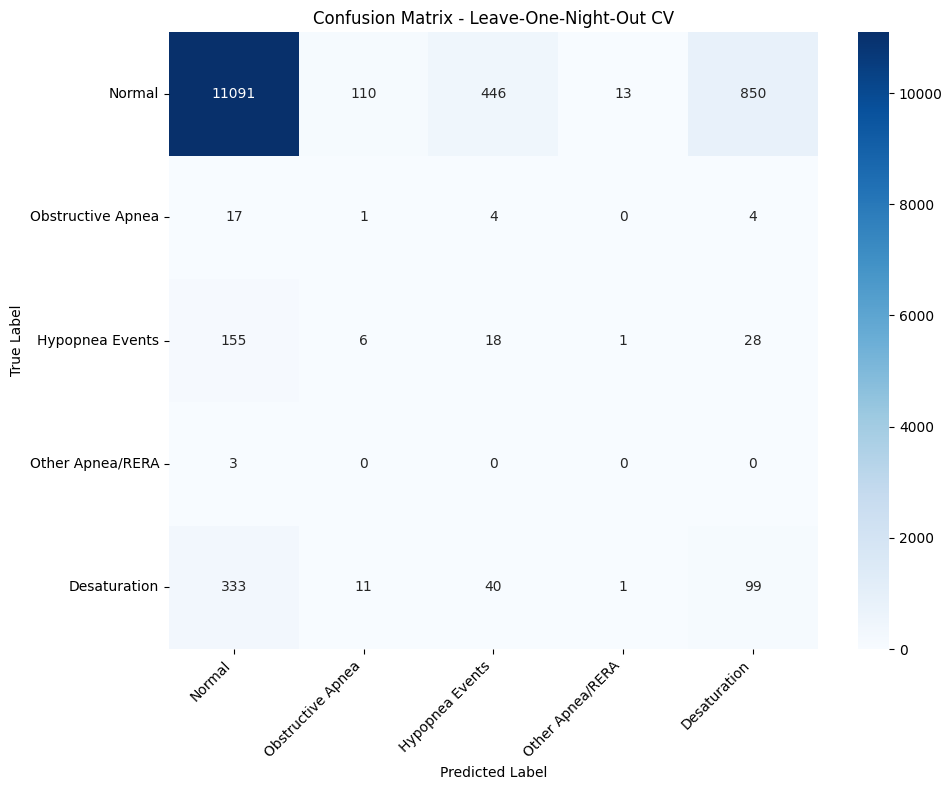

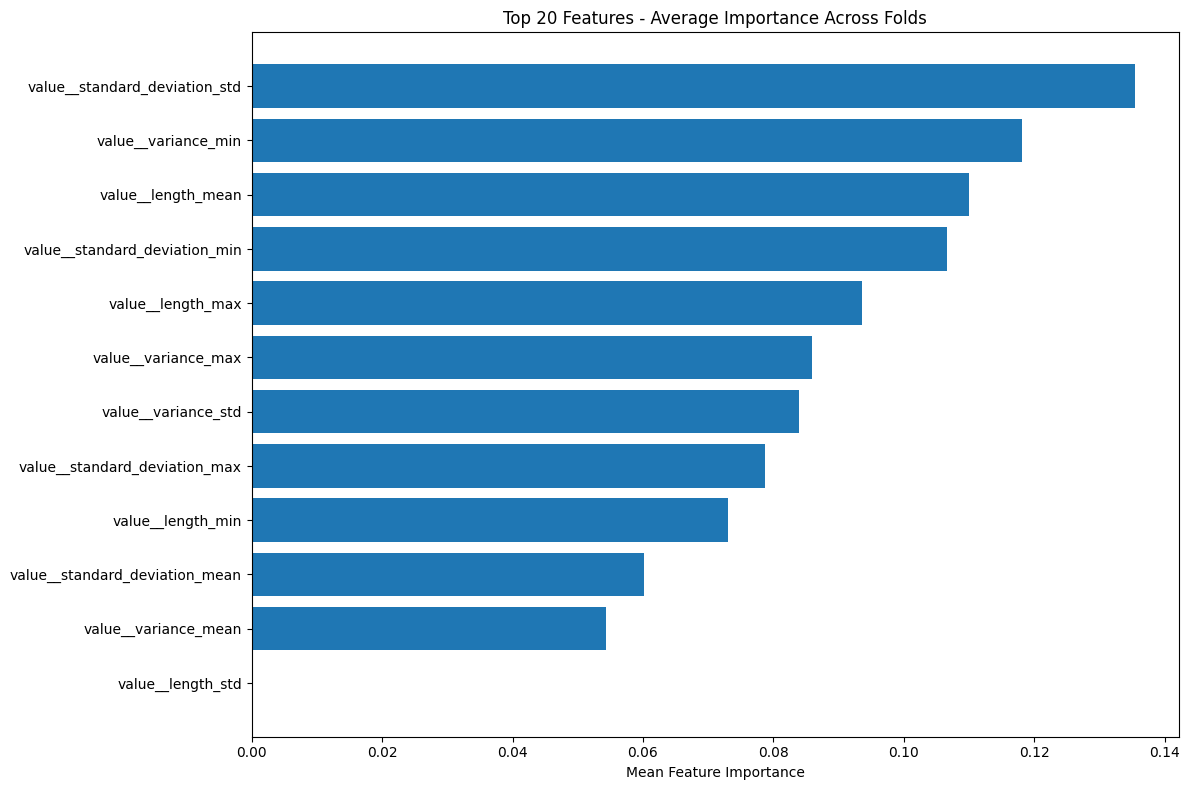


PIPELINE COMPLETE!
Dataset: 13231 samples, 12 features
Sessions: 9
Feature type: TSFresh only

OPTIONAL: COMPARISON WITH DIFFERENT FEATURE SETS

Running comparison between feature sets...

--- RESPECK FEATURES ONLY ---
Starting Leave-One-Night-Out Cross-Validation...
Using 10 features
All classes in dataset: [0 1 2 3 4]
Total number of classes: 5
Number of folds: 9

Fold 1/9 - Testing: 04-04-2025
Train: 6683, Test: 1113
Train distribution: Counter({np.int64(0): 6042, np.int64(4): 414, np.int64(2): 201, np.int64(1): 24, np.int64(3): 2})
Test distribution: Counter({np.int64(0): 1039, np.int64(4): 66, np.int64(2): 6, np.int64(1): 2})


[I 2025-07-29 16:29:23,707] A new study created in memory with name: no-name-cefe0593-f8e7-4926-9492-94f3bafe858c


Resampled: Counter({np.int64(0): 6042, np.int64(2): 6042, np.int64(4): 6042, np.int64(1): 6042, np.int64(3): 6042})
Optimizing hyperparameters...
Target class 1 encoded as 1


[I 2025-07-29 16:29:29,662] Trial 0 finished with value: 0.9304676837943896 and parameters: {'n_estimators': 494, 'max_depth': 5, 'learning_rate': 0.01422048702088535, 'subsample': 0.8826813339985556, 'colsample_bytree': 0.6142259311731999, 'reg_alpha': 2.3691817983769643, 'reg_lambda': 6.786857370217059e-08}. Best is trial 0 with value: 0.9304676837943896.
[I 2025-07-29 16:29:34,853] Trial 1 finished with value: 0.9251247402999315 and parameters: {'n_estimators': 499, 'max_depth': 4, 'learning_rate': 0.021387684222825123, 'subsample': 0.7722540344510698, 'colsample_bytree': 0.7773250779091688, 'reg_alpha': 0.002100829507990438, 'reg_lambda': 0.008199096616653533}. Best is trial 0 with value: 0.9304676837943896.
[I 2025-07-29 16:29:42,564] Trial 2 finished with value: 0.9796297788248117 and parameters: {'n_estimators': 327, 'max_depth': 8, 'learning_rate': 0.02119175915361077, 'subsample': 0.6851056561682071, 'colsample_bytree': 0.6931764888084336, 'reg_alpha': 0.0007817095476660388, '

Best score: 0.9896
Fold accuracy: 0.2768

Fold 2/9 - Testing: 05-04-2025
Train: 6937, Test: 859
Train distribution: Counter({np.int64(0): 6402, np.int64(4): 348, np.int64(2): 164, np.int64(1): 21, np.int64(3): 2})
Test distribution: Counter({np.int64(0): 679, np.int64(4): 132, np.int64(2): 43, np.int64(1): 5})
Resampled: Counter({np.int64(0): 6402, np.int64(2): 6402, np.int64(4): 6402, np.int64(1): 6402, np.int64(3): 6402})
Fold accuracy: 0.3036

Fold 3/9 - Testing: 08-05-2025
Train: 7104, Test: 692
Train distribution: Counter({np.int64(0): 6486, np.int64(4): 416, np.int64(2): 175, np.int64(1): 25, np.int64(3): 2})
Test distribution: Counter({np.int64(0): 595, np.int64(4): 64, np.int64(2): 32, np.int64(1): 1})
Resampled: Counter({np.int64(0): 6486, np.int64(2): 6486, np.int64(4): 6486, np.int64(1): 6486, np.int64(3): 6486})
Fold accuracy: 0.2847

Fold 4/9 - Testing: 10-05-2025
Train: 6938, Test: 858
Train distribution: Counter({np.int64(0): 6267, np.int64(4): 447, np.int64(2): 201, np.

/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


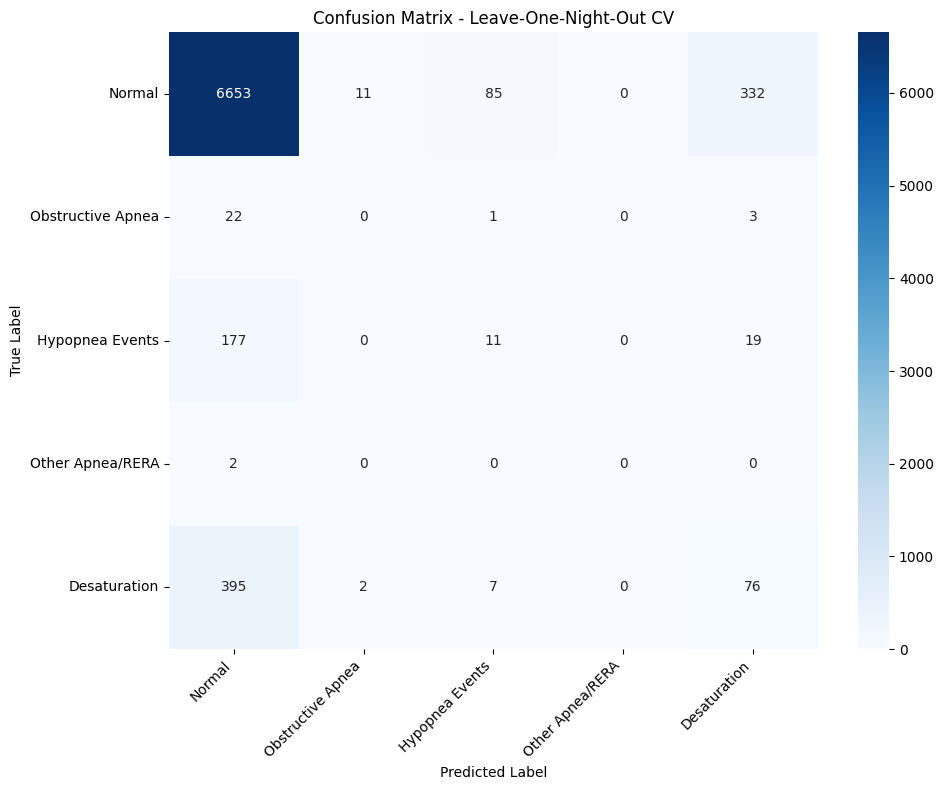

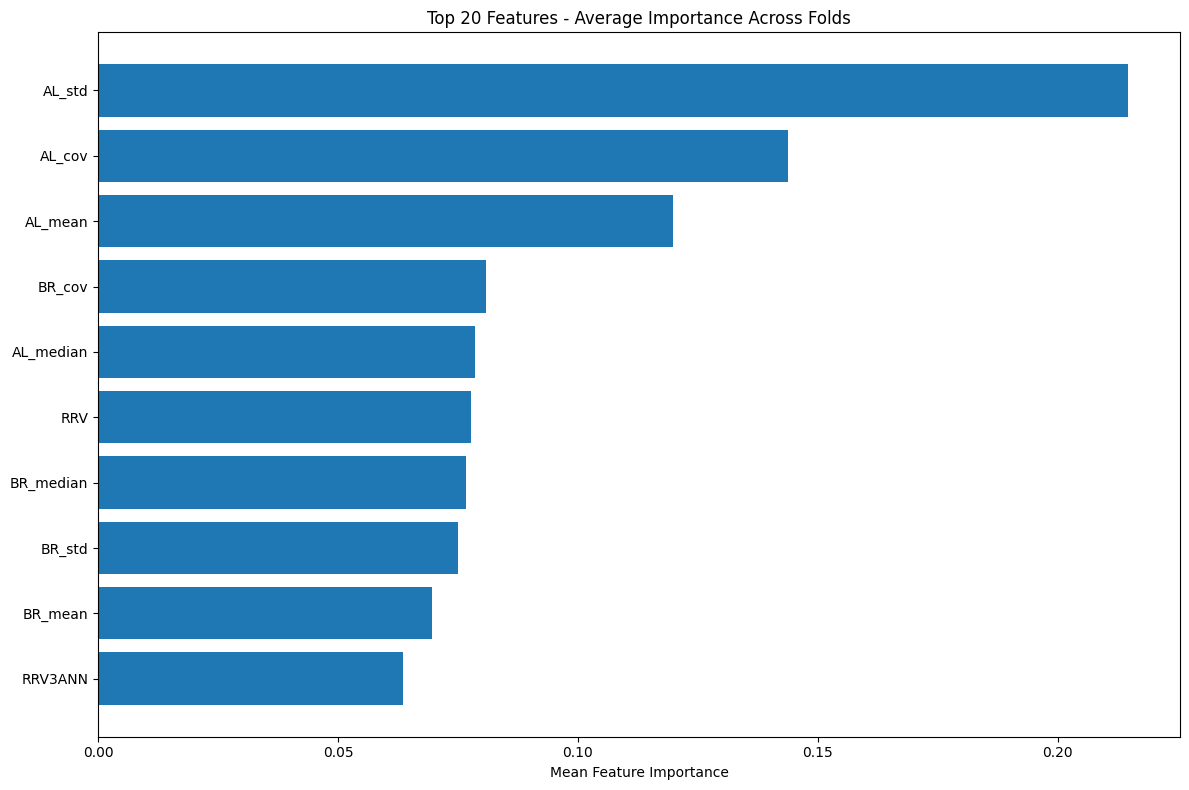


--- TSFRESH FEATURES ONLY ---
Starting Leave-One-Night-Out Cross-Validation...
Using 12 features
All classes in dataset: [0 1 2 3 4]
Total number of classes: 5
Number of folds: 9

Fold 1/9 - Testing: 04-04-2025
Train: 11623, Test: 1608
Train distribution: Counter({np.int64(0): 10976, np.int64(4): 418, np.int64(2): 202, np.int64(1): 24, np.int64(3): 3})
Test distribution: Counter({np.int64(0): 1534, np.int64(4): 66, np.int64(2): 6, np.int64(1): 2})


[I 2025-07-29 16:32:18,311] A new study created in memory with name: no-name-542735de-0db7-4f99-a46c-c8c783feb525


Resampled: Counter({np.int64(1): 10976, np.int64(3): 10976, np.int64(2): 10964, np.int64(4): 10936, np.int64(0): 10928})
Optimizing hyperparameters...
Target class 1 encoded as 1


[I 2025-07-29 16:32:22,516] Trial 0 finished with value: 0.9263375506231307 and parameters: {'n_estimators': 205, 'max_depth': 6, 'learning_rate': 0.05858988272690133, 'subsample': 0.8777365292370536, 'colsample_bytree': 0.8519073134949184, 'reg_alpha': 0.048331997727920024, 'reg_lambda': 8.911178251451359e-07}. Best is trial 0 with value: 0.9263375506231307.
[I 2025-07-29 16:32:27,716] Trial 1 finished with value: 0.9333744691814204 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.0747980584933454, 'subsample': 0.8229149692099476, 'colsample_bytree': 0.6518842042657872, 'reg_alpha': 3.707798208780204e-06, 'reg_lambda': 1.1358337039121082e-08}. Best is trial 1 with value: 0.9333744691814204.
[I 2025-07-29 16:32:35,310] Trial 2 finished with value: 0.9787524006483964 and parameters: {'n_estimators': 405, 'max_depth': 6, 'learning_rate': 0.23583465768797188, 'subsample': 0.8474328725467064, 'colsample_bytree': 0.6818203113835559, 'reg_alpha': 0.01815190606603317, 

Best score: 0.9805


/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fold accuracy: 0.3312

Fold 2/9 - Testing: 05-04-2025
Train: 11008, Test: 2223
Train distribution: Counter({np.int64(0): 10467, np.int64(4): 352, np.int64(2): 165, np.int64(1): 21, np.int64(3): 3})
Test distribution: Counter({np.int64(0): 2043, np.int64(4): 132, np.int64(2): 43, np.int64(1): 5})
Resampled: Counter({np.int64(1): 10467, np.int64(3): 10467, np.int64(2): 10456, np.int64(4): 10443, np.int64(0): 10434})


/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fold accuracy: 0.2893

Fold 3/9 - Testing: 08-05-2025
Train: 12528, Test: 703
Train distribution: Counter({np.int64(0): 11904, np.int64(4): 420, np.int64(2): 176, np.int64(1): 25, np.int64(3): 3})
Test distribution: Counter({np.int64(0): 606, np.int64(4): 64, np.int64(2): 32, np.int64(1): 1})
Resampled: Counter({np.int64(1): 11904, np.int64(3): 11904, np.int64(2): 11886, np.int64(4): 11862, np.int64(0): 11852})


/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fold accuracy: 0.2911

Fold 4/9 - Testing: 10-05-2025
Train: 11872, Test: 1359
Train distribution: Counter({np.int64(0): 11195, np.int64(4): 451, np.int64(2): 202, np.int64(1): 21, np.int64(3): 3})
Test distribution: Counter({np.int64(0): 1315, np.int64(4): 33, np.int64(2): 6, np.int64(1): 5})
Resampled: Counter({np.int64(1): 11195, np.int64(3): 11195, np.int64(2): 11184, np.int64(4): 11143, np.int64(0): 11136})
Fold accuracy: 0.2794

Fold 5/9 - Testing: 11-05-2025
Train: 11878, Test: 1353
Train distribution: Counter({np.int64(0): 11204, np.int64(4): 457, np.int64(2): 193, np.int64(1): 21, np.int64(3): 3})
Test distribution: Counter({np.int64(0): 1306, np.int64(4): 27, np.int64(2): 15, np.int64(1): 5})
Resampled: Counter({np.int64(1): 11204, np.int64(3): 11204, np.int64(2): 11193, np.int64(4): 11167, np.int64(0): 11160})


/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fold accuracy: 0.4182

Fold 6/9 - Testing: 16-04-2025
Train: 10878, Test: 2353
Train distribution: Counter({np.int64(0): 10226, np.int64(4): 446, np.int64(2): 181, np.int64(1): 22, np.int64(3): 3})
Test distribution: Counter({np.int64(0): 2284, np.int64(4): 38, np.int64(2): 27, np.int64(1): 4})
Resampled: Counter({np.int64(3): 10226, np.int64(1): 10225, np.int64(2): 10209, np.int64(4): 10173, np.int64(0): 10161})


/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fold accuracy: 0.2863

Fold 7/9 - Testing: 24-04-2025
Train: 11965, Test: 1266
Train distribution: Counter({np.int64(0): 11338, np.int64(4): 427, np.int64(2): 175, np.int64(1): 24, np.int64(3): 1})
Test distribution: Counter({np.int64(0): 1172, np.int64(4): 57, np.int64(2): 33, np.int64(1): 2, np.int64(3): 2})
Min class size is 1, skipping resampling
Using sample weights due to class imbalance
Fold accuracy: 0.2249

Fold 8/9 - Testing: 25-04-2025
Train: 12026, Test: 1205
Train distribution: Counter({np.int64(0): 11376, np.int64(4): 445, np.int64(2): 179, np.int64(1): 24, np.int64(3): 2})
Test distribution: Counter({np.int64(0): 1134, np.int64(4): 39, np.int64(2): 29, np.int64(1): 2, np.int64(3): 1})
Resampled: Counter({np.int64(1): 11376, np.int64(3): 11376, np.int64(2): 11372, np.int64(4): 11372, np.int64(0): 11368})
Fold accuracy: 0.2093

Fold 9/9 - Testing: 26-04-2025
Train: 12070, Test: 1161
Train distribution: Counter({np.int64(0): 11394, np.int64(4): 456, np.int64(2): 191, np.int

/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


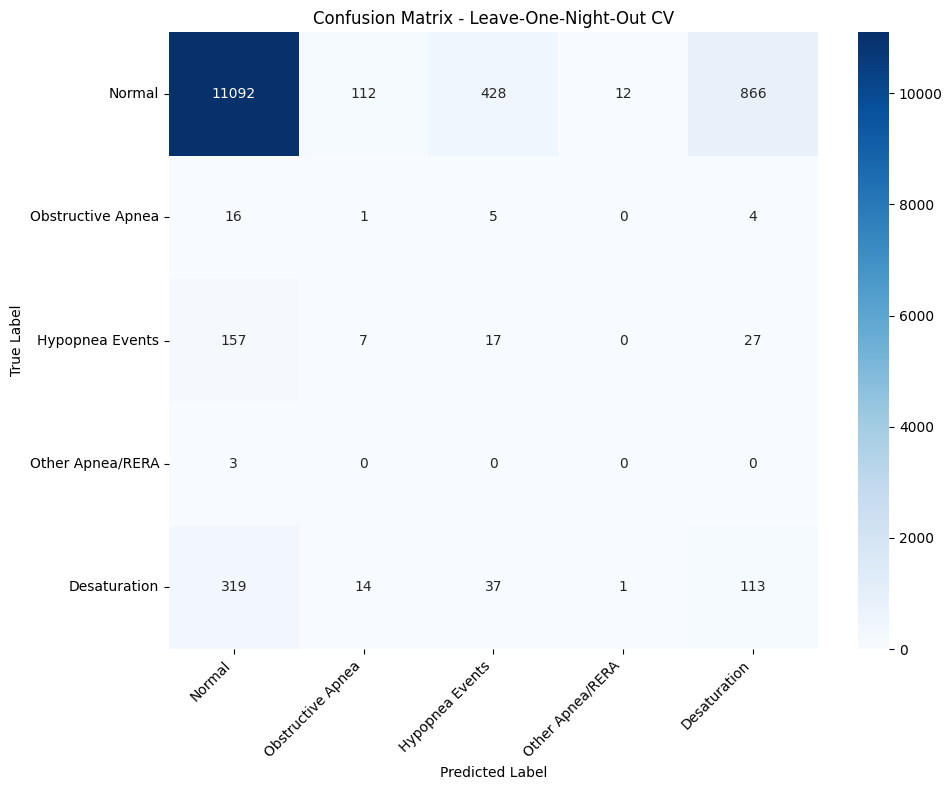

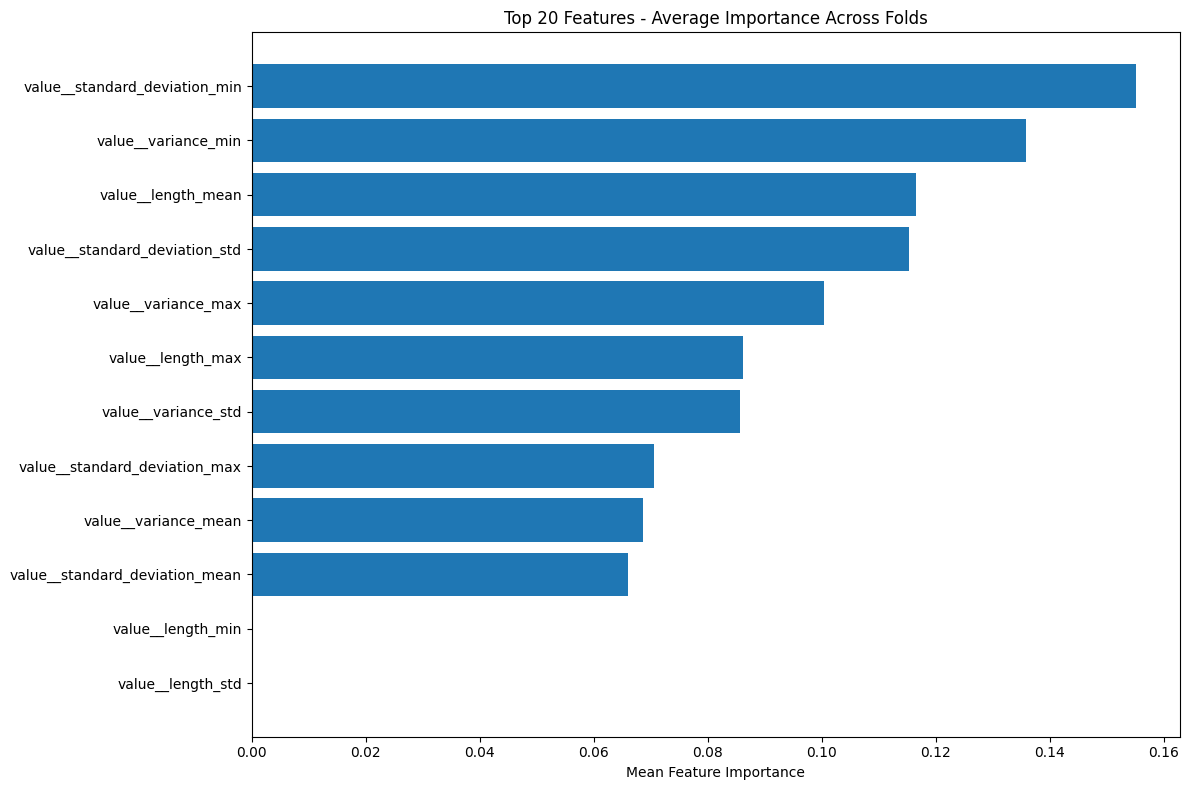

In [8]:
# Complete TSFresh + XGBoost Integration
# This code integrates with your existing pipeline

import pandas as pd
import numpy as np
import glob
import pytz
import os
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
import xgboost as xgb
import optuna
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter

# TSFresh imports
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from tsfresh.feature_selection.relevance import calculate_relevance_table

warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='tsfresh')

# ==========================================
# STEP 1: DATA LOADING (MODIFY THESE PATHS)
# ==========================================

# UPDATE THESE PATHS TO YOUR DATA
EVENTS_FOLDER = '../../data/bishkek_csr/03_train_ready/event_exports' 
RESPECK_FOLDER = '../../data/bishkek_csr/03_train_ready/respeck'
NASAL_FOLDER = '../../data/bishkek_csr/03_train_ready/nasal_files'

# NOTE: Accelerometer data (x,y,z) is in the respeck files

# Your existing event grouping (keep as is)
EVENT_GROUP_TO_LABEL = {
    1: ['Obstructive Apnea'],
    2: ['Hypopnea', 'Central Hypopnea', 'Obstructive Hypopnea'],
    3: ['Central Apnea', 'Mixed Apnea', 'RERA'],
    4: ['Desaturation']
}

LABEL_TO_EVENT_GROUP_NAME = {
    0: 'Normal',
    1: 'Obstructive Apnea',
    2: 'Hypopnea Events',
    3: 'Other Apnea/RERA',
    4: 'Desaturation'
}

# ==========================================
# STEP 2: ENHANCED DATA LOADING WITH ACCELEROMETER
# ==========================================

def prepare_respeck_tsfresh_data(df_respeck, session_id, window_size='30s'):
    """
    Prepare respeck data (including x,y,z accelerometer) for tsfresh feature extraction
    """
    if df_respeck is None or df_respeck.empty:
        return None
    
    print(f"  - Preparing tsfresh data from respeck for session {session_id}")
    
    # Check if accelerometer columns exist
    accel_cols = ['x', 'y', 'z']
    missing_cols = [col for col in accel_cols if col not in df_respeck.columns]
    if missing_cols:
        print(f"  - Warning: Missing accelerometer columns: {missing_cols}")
        return None
    
    # Make a copy and ensure we have the required columns
    df_accel = df_respeck[['timestamp', 'x', 'y', 'z', 'Label']].copy()
    df_accel['SessionID'] = session_id
    
    # Calculate magnitude
    df_accel['magnitude'] = np.sqrt(df_accel['x']**2 + df_accel['y']**2 + df_accel['z']**2)
    
    # Create windows for tsfresh
    df_accel = df_accel.set_index('timestamp')
    windowed_data = []
    
    # Group by time windows
    windows = df_accel.groupby(pd.Grouper(freq=window_size))
    
    for window_start, window_data in windows:
        if len(window_data) < 10:  # Skip very small windows
            continue
            
        # Get most common label in window
        window_label = window_data['Label'].mode().iloc[0] if not window_data['Label'].empty else 0
        
        # Create unique window ID
        window_id = f"{session_id}_{window_start.strftime('%Y%m%d_%H%M%S')}"
        
        # Prepare data for each axis
        for axis in ['x', 'y', 'z', 'magnitude']:
            axis_data = window_data.reset_index()
            axis_data = axis_data[['timestamp', axis]].copy()
            axis_data['id'] = f"{window_id}_{axis}"
            axis_data['time'] = range(len(axis_data))
            axis_data = axis_data.rename(columns={axis: 'value'})
            axis_data['window_id'] = window_id
            axis_data['session_id'] = session_id
            axis_data['label'] = window_label
            axis_data['axis'] = axis
            
            windowed_data.append(axis_data[['id', 'time', 'value', 'window_id', 'session_id', 'label', 'axis']])
    
    if not windowed_data:
        print(f"  - No valid windows created for session {session_id}")
        return None
        
    result_df = pd.concat(windowed_data, ignore_index=True)
    print(f"  - Created {len(result_df['window_id'].unique())} windows with {len(result_df)} time series")
    return result_df

# ==========================================
# STEP 3: ENHANCED DATA LOADING WITH TSFRESH FROM RESPECK
# ==========================================

print("Starting enhanced data loading with tsfresh features from respeck data...")

all_tsfresh_data = []
all_respeck_data = []

event_files = glob.glob(os.path.join(EVENTS_FOLDER, '*_event_export.csv'))
print(f"Found {len(event_files)} event files")

for event_file_path in event_files:
    base_name = os.path.basename(event_file_path)
    session_id = base_name.split('_event_export.csv')[0]
    
    print(f"\nProcessing session: {session_id}")
    
    # Load event data
    df_events = pd.read_csv(event_file_path, decimal=',')
    df_events.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True)
    df_events['timestamp_unix'] = pd.to_numeric(df_events['timestamp_unix'], errors='coerce')
    df_events.dropna(subset=['timestamp_unix'], inplace=True)
    df_events['timestamp_unix'] = df_events['timestamp_unix'].astype('int64')
    
    # Load respeck data
    respeck_file_path = os.path.join(RESPECK_FOLDER, f'{session_id}_respeck.csv')
    if os.path.exists(respeck_file_path):
        df_respeck = pd.read_csv(respeck_file_path)
        
        # Check what columns are available
        print(f"  - Respeck columns: {df_respeck.columns.tolist()}")
        
        df_respeck.rename(columns={'alignedTimestamp': 'timestamp_unix'}, inplace=True)
        df_respeck['timestamp_unix'] = pd.to_numeric(df_respeck['timestamp_unix'], errors='coerce')
        df_respeck.dropna(subset=['timestamp_unix'], inplace=True)
        df_respeck['timestamp_unix'] = df_respeck['timestamp_unix'].astype('int64')
        
        df_respeck['timestamp'] = pd.to_datetime(df_respeck['timestamp_unix'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Asia/Bishkek')
        df_respeck['Label'] = 0
        
        # Apply labels to respeck data
        df_events_copy = df_events.copy()
        df_events_copy['Duration_ms'] = (df_events_copy['Duration'] * 1000).astype('int64')
        df_events_copy['end_time_unix'] = df_events_copy['timestamp_unix'] + df_events_copy['Duration_ms']
        
        for label_id, event_names_in_group in EVENT_GROUP_TO_LABEL.items():
            df_filtered_events = df_events_copy[df_events_copy['Event'].isin(event_names_in_group)]
            for _, event in df_filtered_events.iterrows():
                df_respeck.loc[df_respeck['timestamp_unix'].between(event['timestamp_unix'], event['end_time_unix']), 'Label'] = label_id
        
        # Set timestamp as index for feature extraction
        df_respeck_indexed = df_respeck.set_index('timestamp')
        
        # Extract traditional respeck features
        def generate_RRV(sliced_signal):
            sliced_signal = sliced_signal.dropna()
            if sliced_signal.empty: return np.nan
            breathingSignal = sliced_signal.values
            N = len(breathingSignal)
            if N < 2: return 0.0
            yf = np.fft.fft(breathingSignal)
            yff = 2.0 / N * np.abs(yf[:N//2])
            if len(yff) < 2: return 0.0
            dc_component_value = np.amax(yff)
            if dc_component_value == 0: return 0.0
            temp_dc_removed = np.delete(yff, np.argmax(yff))
            h1_value = np.amax(temp_dc_removed)
            rrv = 100 - (h1_value / dc_component_value) * 100
            return rrv
        
        def extract_respeck_features(df):
            resampled_df = pd.DataFrame()
            br_resampler = df["breathingRate"].resample('30s')
            resampled_df["BR_median"], resampled_df["BR_mean"], resampled_df["BR_std"] = br_resampler.median(), br_resampler.mean(), br_resampler.std()
            resampled_df["BR_cov"] = resampled_df["BR_std"] / resampled_df["BR_mean"]
            al_resampler = df["activityLevel"].resample('30s')
            resampled_df["AL_median"], resampled_df["AL_mean"], resampled_df["AL_std"] = al_resampler.median(), al_resampler.mean(), al_resampler.std()
            resampled_df["AL_cov"] = resampled_df["AL_std"] / resampled_df["AL_mean"]
            resampled_df["RRV"] = df["breathingSignal"].resample('30s').apply(generate_RRV)
            resampled_df["RRV"] = resampled_df["RRV"].replace(0, np.nan).ffill().bfill()
            resampled_df["RRV3ANN"] = resampled_df["RRV"].rolling(window=3, center=True).mean()
            resampled_df["RRV3ANN"] = resampled_df["RRV3ANN"] * 0.65
            resampled_df['Label'] = df['Label'].resample('30s').apply(lambda x: stats.mode(x)[0] if not x.empty else 0)
            return resampled_df
        
        # Extract traditional respeck features
        respeck_features = extract_respeck_features(df_respeck_indexed).dropna()
        respeck_features['SessionID'] = session_id
        all_respeck_data.append(respeck_features)
        print(f"  - Traditional respeck features: {respeck_features.shape}")
        
        # Prepare tsfresh data from accelerometer columns in respeck
        tsfresh_data = prepare_respeck_tsfresh_data(df_respeck_indexed.reset_index(), session_id)
        if tsfresh_data is not None:
            all_tsfresh_data.append(tsfresh_data)
        else:
            print(f"  - No tsfresh data created for {session_id}")
    
    else:
        print(f"  - Respeck file not found: {respeck_file_path}")

# ==========================================
# STEP 4: TSFRESH FEATURE EXTRACTION
# ==========================================

if all_tsfresh_data:
    print(f"\n{'='*60}")
    print("EXTRACTING TSFRESH FEATURES")
    print(f"{'='*60}")
    
    # Combine all tsfresh data
    combined_tsfresh_data = pd.concat(all_tsfresh_data, ignore_index=True)
    print(f"Total time series for tsfresh: {len(combined_tsfresh_data['id'].unique())}")
    print(f"Total windows: {len(combined_tsfresh_data['window_id'].unique())}")
    
    # Extract features
    print("Extracting tsfresh features (this may take several minutes)...")
    
    # Use minimal features first for testing, then switch to comprehensive
    fc_parameters = MinimalFCParameters()  # Change to ComprehensiveFCParameters() for full feature set
    
    # Fix for multiprocessing issues - use single process for now
    extracted_features = extract_features(
        combined_tsfresh_data,
        column_id="id",
        column_sort="time", 
        column_value="value",
        default_fc_parameters=fc_parameters,
        n_jobs=1,  # Use single process to avoid multiprocessing issues
        disable_progressbar=False
    )
    
    # Impute missing values
    extracted_features = impute(extracted_features)
    print(f"Extracted features shape: {extracted_features.shape}")
    
    # Create metadata
    metadata = combined_tsfresh_data.groupby('id').first()[['window_id', 'session_id', 'label', 'axis']].reset_index()
    
    # Feature selection (optional but recommended)
    print("Performing feature selection...")
    y_for_selection = metadata.set_index('id')['label']
    y_binary = (y_for_selection == 1).astype(int)  # Focus on obstructive apnea
    
    try:
        selected_features = select_features(extracted_features, y_binary)
        print(f"Selected {selected_features.shape[1]} features out of {extracted_features.shape[1]}")
        features_to_use = selected_features
    except:
        print("Feature selection failed, using all features")
        features_to_use = extracted_features
    
    # Aggregate features by window (combine x, y, z, magnitude)
    print("Aggregating features by window...")
    
    features_with_meta = features_to_use.copy()
    features_with_meta = features_with_meta.merge(
        metadata.set_index('id'), 
        left_index=True, 
        right_index=True
    )
    
    # Aggregate by window
    window_features = []
    feature_cols = [col for col in features_with_meta.columns 
                   if col not in ['window_id', 'session_id', 'label', 'axis']]
    
    for window_id in features_with_meta['window_id'].unique():
        window_data = features_with_meta[features_with_meta['window_id'] == window_id]
        
        session_id = window_data['session_id'].iloc[0]
        label = window_data['label'].iloc[0]
        
        # Aggregate features across axes
        aggregated_features = {}
        for col in feature_cols:
            values = window_data[col].values
            aggregated_features[f"{col}_mean"] = np.mean(values)
            aggregated_features[f"{col}_std"] = np.std(values)
            aggregated_features[f"{col}_max"] = np.max(values)
            aggregated_features[f"{col}_min"] = np.min(values)
        
        aggregated_features['window_id'] = window_id
        aggregated_features['session_id'] = session_id
        aggregated_features['label'] = label
        
        window_features.append(aggregated_features)
    
    tsfresh_final_df = pd.DataFrame(window_features)
    print(f"Final tsfresh features: {tsfresh_final_df.shape}")
    
else:
    print("No accelerometer data found, proceeding with respeck-only features")
    tsfresh_final_df = None

# ==========================================
# STEP 5: COMBINE WITH RESPECK FEATURES (OPTIONAL)
# ==========================================

if all_respeck_data:
    respeck_df = pd.concat(all_respeck_data).reset_index().rename(columns={'index': 'timestamp'})
    print(f"Respeck features shape: {respeck_df.shape}")
    
    if tsfresh_final_df is not None:
        print("Combining tsfresh and respeck features...")
        
        # Align timestamps (this is tricky - you may need to adjust based on your data)
        # For now, we'll use them separately and compare
        
        # OPTION 1: Use only tsfresh features
        final_features_df = tsfresh_final_df
        print("Using tsfresh features only")
        
        # OPTION 2: Use only respeck features  
        # final_features_df = respeck_df
        # print("Using respeck features only")
        
        # OPTION 3: Combine if you can align timestamps properly
        # This requires careful timestamp alignment between accelerometer and respeck data
        
    else:
        final_features_df = respeck_df
        print("Using respeck features only (no accelerometer data)")
else:
    if tsfresh_final_df is not None:
        final_features_df = tsfresh_final_df
        print("Using tsfresh features only (no respeck data)")
    else:
        raise ValueError("No features available - need either respeck or accelerometer data")

# ==========================================
# STEP 6: PREPARE FOR XGBOOST
# ==========================================

print(f"\n{'='*60}")
print("PREPARING FOR XGBOOST CLASSIFICATION")
print(f"{'='*60}")

# Determine feature columns
if 'BR_median' in final_features_df.columns:
    # Respeck features
    FEATURE_COLUMNS = ['BR_median', 'BR_mean', 'BR_std', 'BR_cov', 
                      'AL_median', 'AL_mean', 'AL_std', 'AL_cov', 'RRV', 'RRV3ANN']
else:
    # TSFresh features
    FEATURE_COLUMNS = [col for col in final_features_df.columns 
                      if col not in ['window_id', 'session_id', 'label', 'SessionID', 'Label', 'timestamp']]

print(f"Using {len(FEATURE_COLUMNS)} features")
print(f"Final dataset shape: {final_features_df.shape}")

# Prepare data
label_col = 'label' if 'label' in final_features_df.columns else 'Label'
session_col = 'session_id' if 'session_id' in final_features_df.columns else 'SessionID'

X = final_features_df[FEATURE_COLUMNS].values
y = final_features_df[label_col].values
groups = final_features_df[session_col].values

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Class distribution: {Counter(y)}")
print(f"Unique sessions: {len(np.unique(groups))}")

# ==========================================
# STEP 7: RUN XGBOOST WITH LEAVE-ONE-NIGHT-OUT CV
# ==========================================

print(f"\n{'='*60}")
print("RUNNING XGBOOST CLASSIFICATION")
print(f"{'='*60}")

# Your enhanced XGBoost class (simplified version)
class TSFreshXGBoostClassifier:
    def __init__(self, target_class_label=1, random_state=42):
        self.target_class_label = target_class_label
        self.random_state = random_state
        self.best_params = None
        self.le = None
        self.feature_names = None  # Store feature names for this instance
    
    def optimize_hyperparameters(self, X_train, y_train, n_trials=30):
        print("Optimizing hyperparameters...")
        
        target_class_encoded = -1
        if self.target_class_label in self.le.classes_:
            target_class_encoded = self.le.transform([self.target_class_label])[0]
            print(f"Target class {self.target_class_label} encoded as {target_class_encoded}")
        else:
            print(f"Target class {self.target_class_label} not found in training data")
        
        def custom_scorer(y_true, y_pred):
            if target_class_encoded == -1 or target_class_encoded not in y_true:
                return balanced_accuracy_score(y_true, y_pred)
            
            f1_scores = f1_score(y_true, y_pred, average=None, zero_division=0)
            unique_labels = np.unique(y_true)
            
            weights = np.ones(len(unique_labels)) * 0.1
            if target_class_encoded in unique_labels:
                target_idx = np.where(unique_labels == target_class_encoded)[0][0]
                weights[target_idx] = 0.7
            
            weights = weights / weights.sum()
            return np.sum(f1_scores * weights)
        
        def objective(trial):
            params = {
                'objective': 'multi:softmax',
                'num_class': len(self.le.classes_),
                'eval_metric': 'mlogloss',
                'random_state': self.random_state,
                'n_jobs': 1,  # Use single process
                'verbosity': 0,
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            }
            
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.random_state)
            scores = []
            
            for train_idx, val_idx in skf.split(X_train, y_train):
                X_tr, X_val = X_train[train_idx], X_train[val_idx]
                y_tr, y_val = y_train[train_idx], y_train[val_idx]
                
                # Handle missing classes in validation folds too
                unique_train_classes = np.unique(y_tr)
                missing_classes = np.setdiff1d(self.le.classes_, unique_train_classes)
                
                if len(missing_classes) > 0:
                    # Add dummy samples
                    dummy_features = np.mean(X_tr, axis=0, keepdims=True)
                    for missing_class in missing_classes:
                        X_tr = np.vstack([X_tr, dummy_features])
                        y_tr = np.append(y_tr, missing_class)
                
                model = xgb.XGBClassifier(**params)
                model.fit(X_tr, y_tr)
                y_pred = model.predict(X_val)
                
                scores.append(custom_scorer(y_val, y_pred))
            
            return np.mean(scores)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        
        self.best_params = study.best_params
        print(f"Best score: {study.best_value:.4f}")
        
        return self.best_params
    
    def cross_validate(self, X, y, groups, feature_names=None):
        print("Starting Leave-One-Night-Out Cross-Validation...")
        
        # Store feature names for this instance
        if feature_names is not None:
            self.feature_names = feature_names
        else:
            self.feature_names = [f"feature_{i}" for i in range(X.shape[1])]
        
        print(f"Using {len(self.feature_names)} features")
        
        # Fit label encoder on ALL data first to ensure consistent class mapping
        self.le = LabelEncoder()
        y_encoded = self.le.fit_transform(y)
        n_classes = len(self.le.classes_)
        
        print(f"All classes in dataset: {self.le.classes_}")
        print(f"Total number of classes: {n_classes}")
        
        all_preds, all_true = [], []
        all_importances = []
        
        logo = LeaveOneGroupOut()
        n_folds = logo.get_n_splits(X, y_encoded, groups)
        
        print(f"Number of folds: {n_folds}")
        
        for fold, (train_idx, test_idx) in enumerate(logo.split(X, y_encoded, groups)):
            test_night = np.unique(groups[test_idx])[0]
            print(f"\nFold {fold+1}/{n_folds} - Testing: {test_night}")
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
            
            print(f"Train: {len(X_train)}, Test: {len(X_test)}")
            print(f"Train distribution: {Counter(y_train)}")
            print(f"Test distribution: {Counter(y_test)}")
            
            # Check for missing classes in training data
            unique_train_classes = np.unique(y_train)
            missing_classes = np.setdiff1d(self.le.classes_, unique_train_classes)
            
            if len(missing_classes) > 0:
                print(f"Missing classes in training fold: {missing_classes}")
                print("Adding dummy samples for missing classes...")
                
                # Add dummy samples for missing classes
                X_train_aug = X_train.copy()
                y_train_aug = y_train.copy()
                
                # Create dummy features (mean of existing training data)
                dummy_features = np.mean(X_train, axis=0, keepdims=True)
                
                for missing_class in missing_classes:
                    X_train_aug = np.vstack([X_train_aug, dummy_features])
                    y_train_aug = np.append(y_train_aug, missing_class)
                
                X_train, y_train = X_train_aug, y_train_aug
                print(f"Updated train distribution: {Counter(y_train)}")
            
            # Scale features
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Handle class imbalance (but be careful with dummy samples)
            class_counts = Counter(y_train)
            min_class_size = min(class_counts.values())
            
            if min_class_size >= 2:
                try:
                    # Use SMOTE only if we have enough samples
                    smote_k = min(min_class_size - 1, 5)  # Conservative k_neighbors
                    smote_tomek = SMOTETomek(
                        smote=SMOTE(k_neighbors=smote_k, random_state=self.random_state),
                        random_state=self.random_state, 
                        n_jobs=1  # Use single process to avoid issues
                    )
                    X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)
                    print(f"Resampled: {Counter(y_train_resampled)}")
                except Exception as e:
                    print(f"SMOTE failed ({e}), using original data")
                    X_train_resampled, y_train_resampled = X_train_scaled, y_train
            else:
                print(f"Min class size is {min_class_size}, skipping resampling")
                X_train_resampled, y_train_resampled = X_train_scaled, y_train
            
            # Optimize on first fold
            if fold == 0:
                self.optimize_hyperparameters(X_train_resampled, y_train_resampled)
            
            # Train model with explicit class specification
            params = self.best_params or {}
            params.update({
                'objective': 'multi:softmax',
                'num_class': n_classes,  # Use the total number of classes
                'eval_metric': 'mlogloss',
                'random_state': self.random_state,
                'n_jobs': 1,  # Use single process
                'verbosity': 0
            })
            
            model = xgb.XGBClassifier(**params)
            
            # Fit with sample weights for class balance if needed
            fit_params = {}
            if min_class_size == 1:  # If we have dummy samples, use class weights
                class_weights = compute_class_weight('balanced', classes=self.le.classes_, y=y_train_resampled)
                sample_weights = np.array([class_weights[self.le.classes_ == label][0] for label in y_train_resampled])
                fit_params['sample_weight'] = sample_weights
                print("Using sample weights due to class imbalance")
            
            model.fit(X_train_resampled, y_train_resampled, **fit_params)
            
            # Predict
            y_pred = model.predict(X_test_scaled)
            all_preds.extend(y_pred)
            all_true.extend(y_test)
            
            # Feature importance - use stored feature names
            importance_df = pd.DataFrame({
                'feature': self.feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            all_importances.append(importance_df)
            
            fold_acc = balanced_accuracy_score(y_test, y_pred)
            print(f"Fold accuracy: {fold_acc:.4f}")
        
        self.display_results(all_true, all_preds, all_importances)
    
    def display_results(self, y_true, y_pred, importances):
        print(f"\n{'='*60}")
        print("FINAL RESULTS")
        print(f"{'='*60}")
        
        y_true_orig = self.le.inverse_transform(y_true)
        y_pred_orig = self.le.inverse_transform(y_pred)
        
        class_names = [LABEL_TO_EVENT_GROUP_NAME[c] for c in self.le.classes_]
        
        print(f"Overall Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_true_orig, y_pred_orig, target_names=class_names, zero_division=0))
        
        # Confusion Matrix
        cm = confusion_matrix(y_true_orig, y_pred_orig, labels=self.le.classes_)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix - Leave-One-Night-Out CV')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Feature Importance
        all_imp_df = pd.concat(importances)
        mean_imp_df = all_imp_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
        
        plt.figure(figsize=(12, 8))
        top_features = mean_imp_df.head(20)
        plt.barh(range(len(top_features)), top_features.values)
        plt.yticks(range(len(top_features)), top_features.index)
        plt.xlabel('Mean Feature Importance')
        plt.title('Top 20 Features - Average Importance Across Folds')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

# ==========================================
# STEP 8: RUN THE COMPLETE PIPELINE
# ==========================================

# Initialize and run the classifier
classifier = TSFreshXGBoostClassifier(target_class_label=1, random_state=42)
classifier.cross_validate(X, y, groups, feature_names=FEATURE_COLUMNS)

print(f"\n{'='*60}")
print("PIPELINE COMPLETE!")
print(f"{'='*60}")
print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Sessions: {len(np.unique(groups))}")
print(f"Feature type: {'TSFresh + Respeck' if 'BR_median' in str(FEATURE_COLUMNS) else 'TSFresh only' if tsfresh_final_df is not None else 'Respeck only'}")

# ==========================================
# STEP 9: ALTERNATIVE - COMPARISON RUNS
# ==========================================

print(f"\n{'='*60}")
print("OPTIONAL: COMPARISON WITH DIFFERENT FEATURE SETS")
print(f"{'='*60}")

# If you have both tsfresh and respeck features, you can compare them
if tsfresh_final_df is not None and all_respeck_data:
    print("\nRunning comparison between feature sets...")
    
    # Run with respeck features only
    print("\n--- RESPECK FEATURES ONLY ---")
    respeck_features_only = ['BR_median', 'BR_mean', 'BR_std', 'BR_cov', 
                            'AL_median', 'AL_mean', 'AL_std', 'AL_cov', 'RRV', 'RRV3ANN']
    
    if all(col in respeck_df.columns for col in respeck_features_only):
        X_respeck = respeck_df[respeck_features_only].values
        y_respeck = respeck_df['Label'].values
        groups_respeck = respeck_df['SessionID'].values
        
        X_respeck = SimpleImputer(strategy='mean').fit_transform(X_respeck)
        
        classifier_respeck = TSFreshXGBoostClassifier(target_class_label=1, random_state=42)
        classifier_respeck.cross_validate(X_respeck, y_respeck, groups_respeck, feature_names=respeck_features_only)
    
    # Run with tsfresh features only
    print("\n--- TSFRESH FEATURES ONLY ---")
    tsfresh_features_only = [col for col in tsfresh_final_df.columns 
                            if col not in ['window_id', 'session_id', 'label']]
    
    X_tsfresh = tsfresh_final_df[tsfresh_features_only].values
    y_tsfresh = tsfresh_final_df['label'].values
    groups_tsfresh = tsfresh_final_df['session_id'].values
    
    X_tsfresh = SimpleImputer(strategy='mean').fit_transform(X_tsfresh)
    
    classifier_tsfresh = TSFreshXGBoostClassifier(target_class_label=1, random_state=42)
    classifier_tsfresh.cross_validate(X_tsfresh, y_tsfresh, groups_tsfresh, feature_names=tsfresh_features_only)

# ==========================================
# STEP 10: SAVE RESULTS (OPTIONAL)
# ==========================================

# print(f"\n{'='*60}")
# print("SAVING RESULTS")
# print(f"{'='*60}")

# # Save extracted features for future use
# if tsfresh_final_df is not None:
#     tsfresh_final_df.to_csv('tsfresh_features.csv', index=False)
#     print("TSFresh features saved to 'tsfresh_features.csv'")

# if all_respeck_data:
#     respeck_df.to_csv('respeck_features.csv', index=False)
#     print("Respeck features saved to 'respeck_features.csv'")

# # Save feature importance
# if 'all_importances' in locals():
#     importance_summary = pd.concat(all_importances).groupby('feature')['importance'].agg(['mean', 'std']).reset_index()
#     importance_summary.to_csv('feature_importance.csv', index=False)
#     print("Feature importance saved to 'feature_importance.csv'")

# print("\n" + "="*60)
# print("SETUP COMPLETE - TO RUN THIS CODE:")
# print("="*60)
# print("1. Update the folder paths at the top of the script:")
# print("   - EVENTS_FOLDER")
# print("   - RESPECK_FOLDER") 
# print("2. Ensure your respeck CSV files contain x, y, z columns")
# print("3. Run the script - it will:")
# print("   - Load your event and respeck data")
# print("   - Extract traditional respeck features (BR, AL, RRV)")
# print("   - Extract tsfresh features from x, y, z accelerometer data")
# print("   - Combine both feature sets or run them separately")
# print("   - Run leave-one-night-out cross-validation")
# print("   - Display results and feature importance")
# print("   - Save features for future use")
# print("\nThe script will automatically detect if x,y,z columns exist in respeck data")
# print("For faster testing, use MinimalFCParameters() initially")
# print("Switch to ComprehensiveFCParameters() for full feature extraction")
# print("="*60)